# Simulation validation of `multidms` models

### Overview


The bloom lab developed a [pipeline to simulate DMS data](https://jbloomlab.github.io/dms_variants/codonvariant_sim_data.html) to test `dms_variants` global epistasis fitting. Here, we build upon the pipeline by simulating data for two homologs, introducing shifts in mutational effects at a subset of sites, with the goal validating the `multidms` joint-fitting approach.

This notebook has 4 major steps involved:

1. Simulate sequences, and respective mutational effects for two homologs -- introducing _shifts_ at a subset of sites for the non-reference homolog.
2. Define replicate libraries of variants, Simulating pre, and post-selection library variant counts from a bottleneck, then computing functional scores as noisy target for fitting.
3. `multidms` model fitting.
4. Model selection criteria and evaluation.

## Setup for analysis

### Import `Python` modules


For this analysis, we'll be using the `dms_variants` package for simulation. All dependencies needed can be installed by cloning the `multidms` repo and executing the command:

```
$ pip install '.[dev]'
```

In [1]:
import warnings
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import Bio.Seq
import itertools
import random
import dms_variants.codonvarianttable
import dms_variants.globalepistasis
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP, AAS_NOSTOP, AA_TO_CODONS, AAS_WITHSTOP
from plotnine import *
import multidms
from collections import defaultdict

### Define notebook parameters

Set parameters that define this notebook's behavior. These can all be modifed (using `papermill`) to reasonable values and the notebook should execute as expected.

In [2]:
seed = 24  # random number seed

# define the reference protein sequence we're going to simulate
genelength = 50  # gene length in codons
wt_latent = 5.0 # wildtype latent phenotype
# min_observednrichment = 0.001 # just for comparison to jesse's method
stop_effect = -15 # -15 is the default for `SigmoidPhenotypeSimulator` object
norm_weights=((0.4, -0.5, 1.2), (0.6, -4, 3)) # See `SigmoidPhenotypeSimulator` for more details

# define the non reference sequence attributes.
n_non_identical_sites = 10 # number of amino-acid mutations separating homologs
min_muteffect_in_bundle = -1.0 # minimum effect per mutation
max_muteffect_in_bundle = 1.0 # maximum effect per mutation
n_shifted_non_identical_sites = 4 # number of non identical sites (in the bundle) for which mutations at that site are expected to have shifted effects
n_shifted_identical_sites = 6 # number of amino-acid mutations separating shifted
shift_gauss_variance = 1.0 # variance of the gaussian distribution from which the shifted effects are drawn

# define the sigmoid phenotype parameters. See `multidms.biophysical.sigmoidal_global_epistasis` for more details.
# sigmoid_phenotype_bias = -6
sigmoid_phenotype_scale = 6

# define the libraries
variants_per_lib_genelength_scalar = 500  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.0 #0.005  # rate at which variant sequence mis-called
avgdepth_per_variant = 200  # average per-variant sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection

# bottlenecks from pre- to post-selection
bottleneck_variants_per_lib_scalar = {
    "tight_bottle": 5,
    "loose_bottle": 100,
}

iterations_per_step = 10000 # default 20000
scale_coeff_lasso_shift = [0.0, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 1e-3] # the sweep of lasso coefficient params
init_beta_naught = 5.0 # We've found that we need to start with a higher beta_naught to get the model to converge correctly,
scale_coeff_ridge_beta = 0.0 # the sweep of ridge coefficient params

# model fitting parameters
train_frac = 0.8 # fraction of data to use for cross validation training.

lasso_choice = 1e-4

In [3]:
# Set some configurations and a few other more experimental parameters which could break things if not set correctly:
random.seed(seed)
np.random.seed(seed)
warnings.simplefilter('ignore')

libs = ["lib_1", "lib_2"]  # distinct libraries of gene
noise = 0.0 # 0.05

variants_per_lib = variants_per_lib_genelength_scalar * genelength

bottlenecks = {
    name : variants_per_lib * scalar
    for name, scalar in bottleneck_variants_per_lib_scalar.items()
}

fitting_params = {
    "iterations_per_step": [iterations_per_step], # default 20000
    "scale_coeff_lasso_shift": scale_coeff_lasso_shift, # the sweep of lasso coefficient params
    "init_beta_naught" : [init_beta_naught], # We've found that we need to start with a higher beta_naught to get the model to converge correctly,
    "scale_coeff_ridge_beta" : [scale_coeff_ridge_beta], # the sweep of ridge coefficient params
}


## Simulating reference sequence and mutational effects

### Simulate a reference sequence


Start by simulating a sequence of nucleotides, then translate it to amino acids. We'll use this sequence as the reference sequence for the simulated datasets.

In [4]:
geneseq_h1 = "".join(random.choices(CODONS_NOSTOP, k=genelength))
aaseq_h1 = str(Bio.Seq.Seq(geneseq_h1).translate())
print(f"Wildtype gene of {genelength} codons:\n{geneseq_h1}")
print(f"Wildtype protein:\n{aaseq_h1}")

Wildtype gene of 50 codons:
GGTTCCAGTTTTAGTGGAACCGTGAGCGGTGTAGTGCGGTCGTTTACTCTTTTCGTCCGTCAGTTCACCGTGTCCAGCCATCAGGACCCGTGCTGTCATTGCACAACCGGATACTATTTTTCGCAAGTCTGTACCCTGAGCAGACTCGGA
Wildtype protein:
GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG


### Mutational effects

Simulate latent mutational effects, $\beta_m$, storing data in a `SigmoidPhenotypeSimulator` object. 

In [5]:
mut_pheno_args = {
    "geneseq" : geneseq_h1,
    "wt_latent" : wt_latent,
    "seed" : seed,
    "stop_effect" : stop_effect,
    # "min_observed_enrichment" : min_observed_enrichment,
    "norm_weights" : norm_weights
}

SigmoidPhenotype_h1 = dms_variants.simulate.SigmoidPhenotypeSimulator(**mut_pheno_args)

#  Also create an identical object for the second homolog. Later, we'll update this object to include shifted mutational effects.
SigmoidPhenotype_h2 = dms_variants.simulate.SigmoidPhenotypeSimulator(**mut_pheno_args)

Plot the distribution of mutation effects for the first homolog.

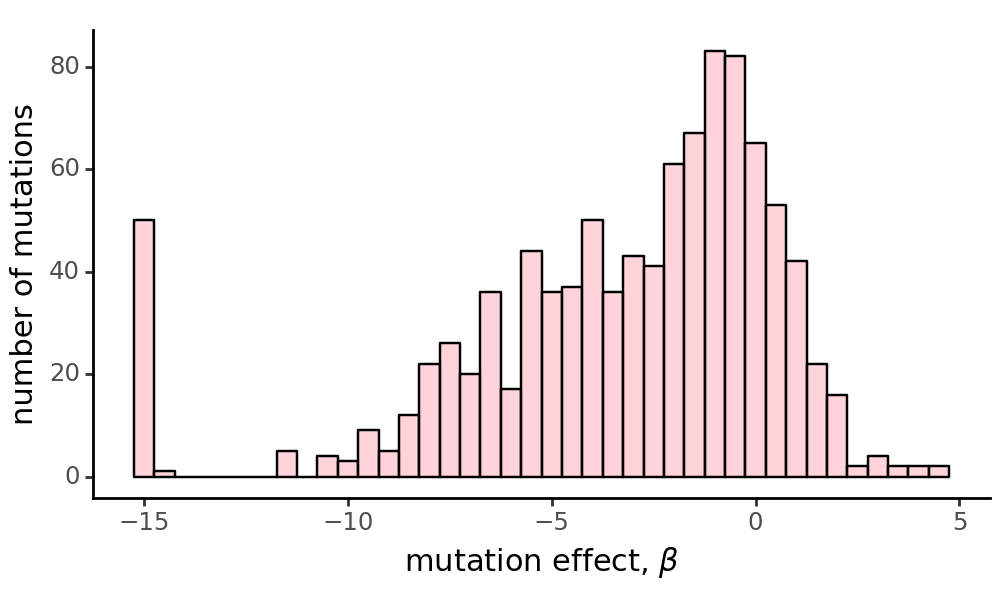

In [62]:
p = (
    ggplot(pd.DataFrame({'muteffects': SigmoidPhenotype_h1.muteffects}),
           aes(x='muteffects'))
    + geom_histogram(binwidth=0.5, color='black', fill='pink', alpha=0.7)
    + xlab("mutation effect, $β$")
    + ylab('number of mutations')
    + theme_classic()
    + theme(figure_size=(5, 3))
)
_ = p.draw(show=True)

As expected, our mutational effects are weighted in the negative direction, as we expect the majority of mutations to be deleterious to a protein.

### Non-reference homolog sequence


Next, we'll simulate the DNA/protein sequence of second homolog by making a defined number of random amino-acid mutations to the first homolog. When choosing the "bundle" of mutation which separate the two homologs, we avoid mutations that decrease or increase the latent phenotype by more than `min_muteffect_in_bundle` and `max_muteffect_in_bundle` respectively. This is to ensure that the latent phenotype of the second homolog is not too different from the first homolog, an important assumption for the `multidms` model.

In [7]:
# Input params
non_identical_sites = sorted(random.sample(range(1, len(aaseq_h1)+1), n_non_identical_sites))
aaseq_h2 = ''
geneseq_h2 = ''


# Iterate over each amino acid in the first homolog, and make a mutation if indicated.
for (aa_n, aa) in enumerate(aaseq_h1, 1):
    codon = geneseq_h1[(aa_n-1)*3:3*aa_n]
    if aa_n in non_identical_sites:
        # define the valid mutations for this site
        valid_bundle_mutations = [
            mut_aa for mut_aa in AAS_NOSTOP
            if (
                (mut_aa != aa) \
                and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] > min_muteffect_in_bundle) \
                and (SigmoidPhenotype_h1.muteffects[f'{aa}{aa_n}{mut_aa}'] < max_muteffect_in_bundle)
            )
        ]
        assert len(valid_bundle_mutations) > 0, aa_n
        mut_aa = random.choice(valid_bundle_mutations)
        aaseq_h2 += mut_aa
        mut_codon = random.choice(AA_TO_CODONS[mut_aa])
        geneseq_h2 += mut_codon
    else:
        aaseq_h2 += aa
        geneseq_h2 += codon

# Store and summarize results
homolog_seqs_df = pd.DataFrame(
    {"wt_aa_h1" : list(aaseq_h1), "wt_aa_h2" : list(aaseq_h2)},
    index = range(1, len(aaseq_h1)+1),
)
homolog_seqs_df.index.name = 'site'

# n_diffs = sum([aa1 != aa2 for (aa1, aa2) in zip(*homolog_seqs.values())])
n_diffs = len(homolog_seqs_df.query('wt_aa_h1 != wt_aa_h2'))
print('Sequence alignment of homologs h1 and h2:')
print('h1', aaseq_h1)
print('h2', aaseq_h2)
print('Number of aa differences:', n_diffs)
assert len(aaseq_h1) == len(aaseq_h2)
assert aaseq_h2 == str(Bio.Seq.Seq(geneseq_h2).translate())
assert n_diffs == len(non_identical_sites)

Sequence alignment of homologs h1 and h2:
h1 GSSFSGTVSGVVRSFTLFVRQFTVSSHQDPCCHCTTGYYFSQVCTLSRLG
h2 GSSFSGTGEGVVRMFTLFVRQFTVSSHQDPCDHCITSDYFSHVETLSRVG
Number of aa differences: 10


### Shifted mutational effects

Next, randomly choose a subset of (identical and non-identical) sites that will have shifted mutational effects. Do this independently for sites that are identical and non-identical between homologs, so that we are sure to have shifted sites in each category.

In [8]:
# Non-identical sites
shifted_non_identical_sites = sorted(random.sample(
    non_identical_sites,
    n_shifted_non_identical_sites
))

# choose a subset of the identical sites to have shifted effects
shifted_identical_sites = sorted(random.sample(
    list(set(range(1, len(aaseq_h1)+1)) - set(non_identical_sites)),
    n_shifted_identical_sites
))

# Make a list of all shifted sites
shifted_sites = sorted(shifted_identical_sites + shifted_non_identical_sites)
assert len(shifted_sites) == len(set(shifted_sites))
print('Sites with shifts that are...')
print(f'identical (n={len(shifted_identical_sites)}):', ', '.join(map(str, shifted_identical_sites)))
print(f'non-identical (n={len(shifted_non_identical_sites)}):', ', '.join(map(str, shifted_non_identical_sites)))

Sites with shifts that are...
identical (n=6): 10, 28, 29, 30, 34, 39
non-identical (n=4): 8, 14, 32, 42


Next, we'll create a dataframe for all mutational effects and shifts, simulating shifts at each of the above sites by randomly simulate a shift in the effect of each mutation by drawing shifts from a Gaussian distribution:

In [9]:
def sim_mut_shift(shifted_site, mutation):
    if (not shifted_site) or ('*' in mutation):
        return 0
    else:
        return np.random.normal(loc=0, scale=shift_gauss_variance, size=1)[0]

# Make a dataframe of mutation effects in the first homolog
mut_effects_df = (
    pd.DataFrame.from_dict(
        SigmoidPhenotype_h1.muteffects,
        orient='index',
        columns=['beta_h1']
    )
    .reset_index()
    .rename(columns={'index':'mutation'})
    .assign(
        wt_aa=lambda x: x['mutation'].apply(lambda y: multidms.data.split_sub(y)[0]),
        site=lambda x: x['mutation'].apply(lambda y: int(multidms.data.split_sub(y)[1])),
        mut_aa=lambda x: x['mutation'].apply(lambda y: multidms.data.split_sub(y)[2]),
        shifted_site=lambda x: x['site'].isin(shifted_sites),
        shift=lambda x: x.apply(
            lambda row: sim_mut_shift(
                row['shifted_site'],
                row['mutation']
            ),
            axis=1
        ),
        beta_h2=lambda x: x['beta_h1'] + x['shift']
    )
    .merge(homolog_seqs_df, left_on='site', right_index=True, how='left')
    .assign(
        bundle_mut = lambda x: x['mut_aa'] == x['wt_aa_h2']
    )
)

# Show data for a subset of sites with shifts
mut_effects_df[mut_effects_df['shifted_site'] == True][[
    'site', 'wt_aa_h1', 'wt_aa_h2', 'mutation',
    'beta_h1', 'shift', 'beta_h2',
    'shifted_site'
]]

site wt_aa_h1 wt_aa_h2 mutation    beta_h1     shift    beta_h2  \
140     8        V        G      V8A  -7.389801  1.329212  -6.060588   
141     8        V        G      V8C  -7.620390 -0.770033  -8.390423   
142     8        V        G      V8D  -7.295378 -0.316280  -7.611658   
143     8        V        G      V8E  -0.729143 -0.990810  -1.719953   
144     8        V        G      V8F  -1.369987 -1.070816  -2.440803   
..    ...      ...      ...      ...        ...       ...        ...   
835    42        Q        H     Q42T   0.959988 -2.870096  -1.910108   
836    42        Q        H     Q42V  -5.127464  0.351710  -4.775753   
837    42        Q        H     Q42W  -0.135438  0.265490   0.130052   
838    42        Q        H     Q42Y  -1.189513  0.105712  -1.083801   
839    42        Q        H     Q42* -15.000000  0.000000 -15.000000   

     shifted_site  
140          True  
141          True  
142          True  
143          True  
144          True  
..            ...  
835          True  
836          True  
837          True  
838          True  
839          True  

[200 rows x 8 columns]

Plot the distribution of all simulated shifts, excluding mutations to stop codons and sites that have no shifted effects.

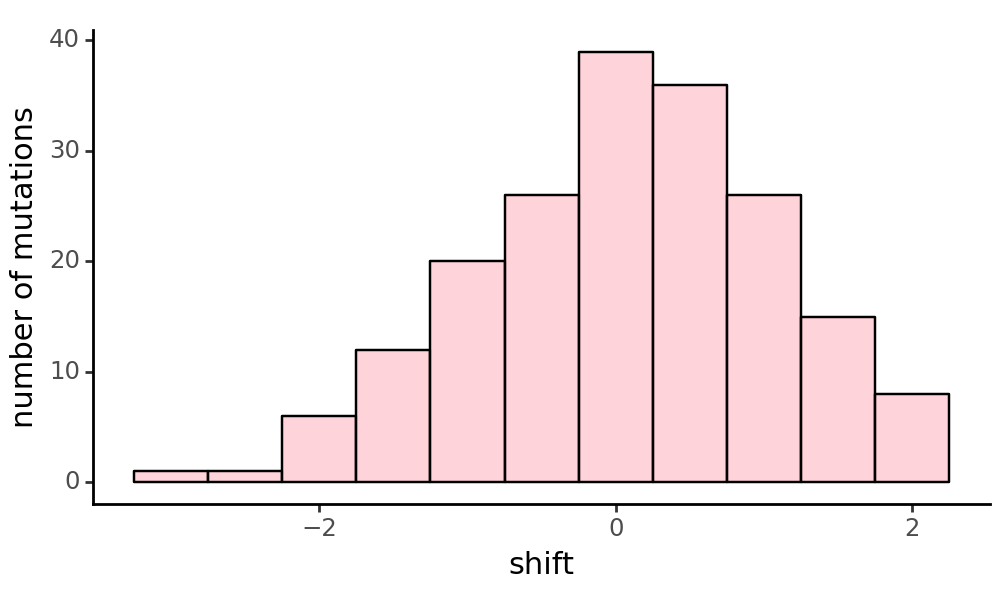

In [10]:
non_stop_shifted_muts = mut_effects_df[
    (mut_effects_df['site'].isin(shifted_sites)) &
    ~(mut_effects_df['mutation'].str.contains('\*'))
]

p = (
    ggplot(non_stop_shifted_muts, aes(x='shift'))
    + geom_histogram(binwidth=0.5, color='black', fill='pink', alpha=0.7)
    + xlab("shift")
    + ylab('number of mutations')
    + theme_classic()
    + theme(figure_size=(5, 3))
)

_ = p.draw(show=True)

We can also plot the shifts as a heatmap, and mark the wildtype amino acid at each site (`x` for reference, `o` for non-reference):

In [11]:
max_abs_value = max(abs(mut_effects_df['shift'].min()), mut_effects_df['shift'].max())
x_scale = [s for s in range(1, len(homolog_seqs_df)+1)]
y_scale = sorted([
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","*",
])

p = (
    ggplot(mut_effects_df)
    + geom_tile(
        aes(x='factor(site)', y='mut_aa', fill='shift', width=.9, height=.9)
    )
    + geom_point(
        homolog_seqs_df.reset_index(),
        aes(
            x='factor(site)', y='wt_aa_h1' #, label='aaseq_h1'
        ),
        color='black',
        size=2,
        shape='x'
    )
    + geom_point(
        homolog_seqs_df.reset_index().query('wt_aa_h1 != wt_aa_h2'),
        aes(
            x='factor(site)', y='wt_aa_h2' #, label='aaseq_h1'
        ),
        color='black',
        size=2,
        shape='o'
    )
    + scale_x_discrete(
        limits = x_scale,
        labels = x_scale
    )
    + scale_y_discrete(
        limits = y_scale,
        labels = y_scale
    )
    + scale_fill_gradientn(
        colors=['red', 'white', 'blue'],
        limits=[-max_abs_value, max_abs_value],
    )
    + theme_classic()
    + theme(figure_size=(9, 3.75))
    + xlab('site')
    + ylab('mutation')
)
_ = p.draw(show=True)

Recal that we have already created a `SigmoidPhenotypeSimulator` object for the second homolog by making a copy of the one for the first homolog. This object stores the homolog's wildtype latent phenotype and the latent effects of individual mutations. Below, we update both of these traits based on the simulated shifts from above. To update the wildtype latent phenotype of the second homolog, we add the effects of all mutations that separate the homologs. In computing this sum, we will use $\beta$ parameters for the second homolog, which already include shifted effects.

In [12]:
# Update individual mutational effects
assert sum(mut_effects_df['mutation'].duplicated()) == 0
for mutation in SigmoidPhenotype_h2.muteffects.keys():
    SigmoidPhenotype_h2.muteffects[mutation] = mut_effects_df.loc[
        mut_effects_df['mutation']==mutation, 'beta_h2'
    ].values[0]

wt_latent_phenotype_shift = mut_effects_df.query("bundle_mut")["beta_h2"].sum()
SigmoidPhenotype_h2.wt_latent = SigmoidPhenotype_h1.wt_latent + wt_latent_phenotype_shift

print('Characteristics of mutations separating homologs:\n')
for metric in ['beta_h1', 'shift', 'beta_h2']:
    print(f'  Sum of {metric}:', round(sum(mut_effects_df.query("bundle_mut")[metric]), 2))
print('  Final WT latent phenotype of h2:', round(SigmoidPhenotype_h2.wt_latent, 2))
print('  Table of mutations that separate homologs:')
mut_effects_df.query("mut_aa == wt_aa_h2")

Characteristics of mutations separating homologs:

  Sum of beta_h1: 0.66
  Sum of shift: -0.48
  Sum of beta_h2: 0.18
  Final WT latent phenotype of h2: 5.18
  Table of mutations that separate homologs:


mutation   beta_h1 wt_aa  site mut_aa  shifted_site     shift   beta_h2  \
145      V8G  0.834349     V     8      G          True -1.438713 -0.604364   
163      S9E -0.705146     S     9      E         False  0.000000 -0.705146   
270     S14M  0.192719     S    14      M          True -1.628753 -1.436034   
621     C32D  0.958833     C    32      D          True  2.106745  3.065578   
687     T35I  0.097535     T    35      I         False  0.000000  0.097535   
734     G37S -0.695803     G    37      S         False  0.000000 -0.695803   
742     Y38D -0.265583     Y    38      D         False  0.000000 -0.265583   
826     Q42H -0.888294     Q    42      H          True  0.483694 -0.404601   
862     C44E  0.136021     C    44      E         False  0.000000  0.136021   
976     L49V  0.996403     L    49      V         False  0.000000  0.996403   

    wt_aa_h1 wt_aa_h2  bundle_mut  
145        V        G        True  
163        S        E        True  
270        S        M        True  
621        C        D        True  
687        T        I        True  
734        G        S        True  
742        Y        D        True  
826        Q        H        True  
862        C        E        True  
976        L        V        True

At this point, all mutations in the second homolog's `SigmoidPhenotypeSimulator` object are defined relative to the wildtype sequence of the first homolog, which we will call the "reference" homolog. However, to compute phenotypes for the second homolog, we still need to assign the effects of mutations at non-identical sites in the "non-reference" homolog. For instance, if the wildtype amino acid at site 30 is an A in the reference homolog, but is a Y in a non-reference homolog, then the effect of a Y30G is absent from the second homolog's simulator object. 

To add these missing entries, we will use a strategy that assumes additivity between mutations at the same site.
For instance, in the above example, the effect of a Y30G mutation is defined as the sum of the A30Y (negated) and A30G effects in the reference homolog.
This approach assumes that mutational effects can be negated, such that A30Y has the opposite effect as Y30A.
It also assumes that mutational effects are additive, such that the effect of Y30G is the sum of the effects of Y30A and A30G.

The below expression defines this approach more explicitly for an arbitrary site.
It uses the notation $\beta_{x,n,z}$ where $x$ and $z$ are amino acids.
For a site $n$, if $aa_{\text{wt}}$ is the site's wildtype amino acid in a non-reference homolog, $aa_{\text{mut}}$ is a mutant amino acid in a variant of that homolog, and $aa_{\text{ref}}$ is the site's wildtype amino acid in the reference homolog, then the mutation's effect is:

$$\beta_{aa_{\text{wt}},n,aa_{\text{mut}}} = \begin{cases}
      \beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{if } aa_{\text{wt}} = aa_{\text{ref}}\\
      -\beta_{aa_{\text{ref}},n,aa_{\text{wt}}} & \text{if } aa_{\text{mut}} = aa_{\text{ref}}\\
      - \beta_{aa_{\text{ref}},n,aa_{\text{wt}}} +\beta_{aa_{\text{ref}},n,aa_{\text{mut}}} & \text{otherwise}\\
\end{cases}$$

The above $\beta$ parameters are effects in the background of the non-reference homolog, such that they account for shifts in mutational effects between homologs. 


The below cell adds mutational effects for missing entries using the above strategy:

In [13]:
# iterate over "bundle" of mutations which disguish the homologs
for idx, row in mut_effects_df.query("mut_aa == wt_aa_h2").iterrows():

    # compute the effect of each possible mutation at a bundle site
    for aa_mut in AAS_WITHSTOP:

        # skip the non-ref wt-to-wt
        if aa_mut == row.wt_aa_h2:
            continue

        non_ref_mutation = f'{row.wt_aa_h2}{row.site}{aa_mut}'

        # stop effect is the same for all homologs
        if aa_mut == '*':
            SigmoidPhenotype_h2.muteffects[non_ref_mutation] = stop_effect

        # back-mutation to reference        
        elif aa_mut == row.wt_aa_h1:
            SigmoidPhenotype_h2.muteffects[non_ref_mutation] = -row.beta_h2

        # all other mutations
        else:            
            ref_mut = f'{row.wt_aa_h1}{row.site}{aa_mut}'
            ref_mut_effect = mut_effects_df.loc[
                mut_effects_df['mutation'] == ref_mut, 'beta_h2'
            ].values[0]
            SigmoidPhenotype_h2.muteffects[non_ref_mutation] = -row.beta_h2 + ref_mut_effect

## Simulate variant libraries and selection

### Variant libraries


Simulate a set of variant libraries that one might use in an actual experiment for each homolog, each with two replicate libraries.

In [14]:
CodonVariantTable_h1 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h1,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)
CodonVariantTable_h2 = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq_h2,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
)

In [15]:
CodonVariantTable_h1.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

plot the number of variant support sequences as a histogram

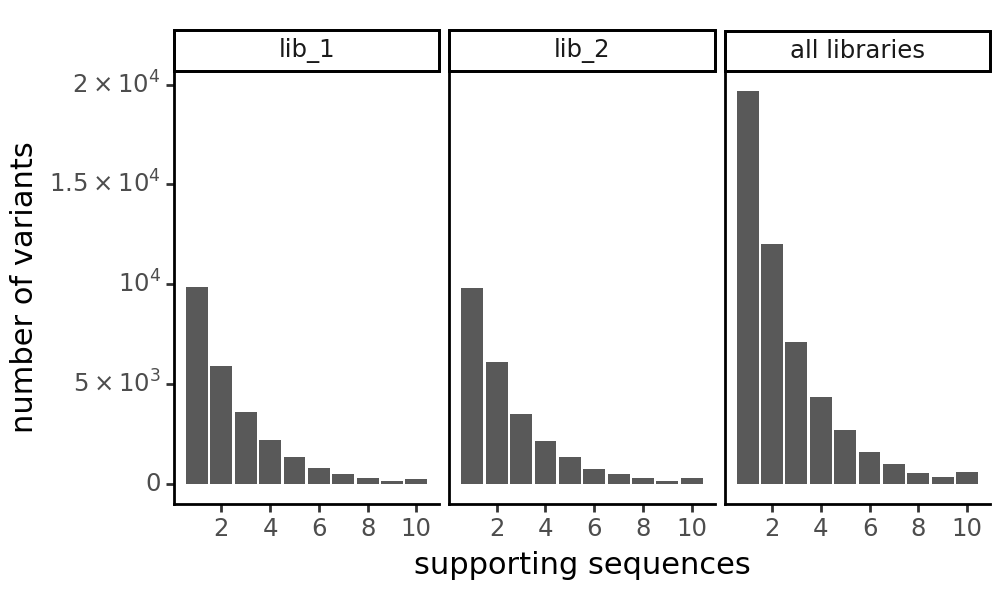

In [16]:
p = CodonVariantTable_h1.plotVariantSupportHistogram(max_support=10)
p += theme_classic() 
p += theme(
    panel_grid_major_x=element_blank(),  # no vertical grid lines
    figure_size=(5, 3)
)
_ = p.draw(show=True)

In [17]:
CodonVariantTable_h2.n_variants_df(samples=None)

library             sample  count
0          lib_1  barcoded variants  25000
1          lib_2  barcoded variants  25000
2  all libraries  barcoded variants  50000

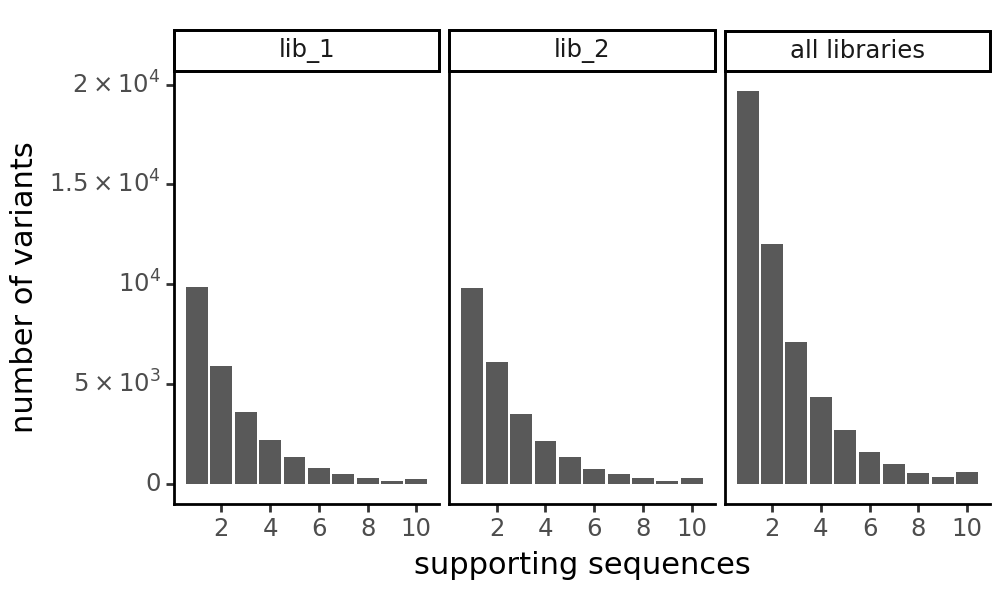

In [18]:
p = CodonVariantTable_h2.plotVariantSupportHistogram(max_support=10)
p += theme_classic() 
p += theme(
    panel_grid_major_x=element_blank(),  # no vertical grid lines
    figure_size=(5, 3)
)
_ = p.draw(show=True)


### Variant phenotypes and enrichments

Now that we have simulated libraries of variants $v_i \in V$, we'll assign their respective ground truth phenotypes and enrichments. 

We'll start by computing latent phenotype, $\phi(v_i)$. Recall that each of the two homologs has a `SigmoidPhenotypeSimulator` object that stores the latent effects of individual mutations. We will use these objects to compute the latent phenotypes of all variants in the libraries.


In [19]:
# we'll store a collection of functions for each homolog
phenotype_fxn_dict_h1 = {"latentPhenotype" : SigmoidPhenotype_h1.latentPhenotype}
phenotype_fxn_dict_h2 = {"latentPhenotype" : SigmoidPhenotype_h2.latentPhenotype}

# add the latent phenotype to the barcode variant table
CodonVariantTable_h1.barcode_variant_df['latent_phenotype'] = CodonVariantTable_h1.barcode_variant_df['aa_substitutions'].apply(
    phenotype_fxn_dict_h1["latentPhenotype"]
)
CodonVariantTable_h2.barcode_variant_df['latent_phenotype'] = CodonVariantTable_h2.barcode_variant_df['aa_substitutions'].apply(
    phenotype_fxn_dict_h2["latentPhenotype"]
)

# print a sample of the variant table
CodonVariantTable_h1.barcode_variant_df[["library", "aa_substitutions", "latent_phenotype"]].head()

library                         aa_substitutions  latent_phenotype
0   lib_1  V24Q S25R H27P D29L H33C S41L C44F S47F        -11.096139
1   lib_1                       V8P H27T P30* L49P        -11.106200
2   lib_1                                V19P V43Q         -2.878203
3   lib_1                                     R20Y          5.161623
4   lib_1                                                   5.000000

Next, we can compute an _observed phenotype_, $p(v, d)$ = $g_{\theta}(\phi(v, d))$, where $g_{\theta}$ is the global epistasis function implimented as a flexible sigmoid with two free parameters, $\theta_{s}$ and $\theta_{b}$, that serve as a scale and bias, respectively. Concretely, $g_{\theta}(z) = \theta_{b} + \frac{\theta_{s}}{1 + e^{-z}}$.

Note that while the `SigmoidPhenotypeSimulator` object provides it's own global epistasis object for computing phenotype and enrichments, we will only be using it to get mutational effects and the associated latent phenotypes. For computing the post-latent phenotypes and enrichments, we will use the `multidms` biophysical model such that we're simulating under the same model we'll be fitting as described above.

In [20]:
# define numpy wrapper for multidms native jax sigmoid fxn
def g(z:float, ge_scale=sigmoid_phenotype_scale, wt_latent=wt_latent):

    # ensure the reference phenotype is 0
    ge_bias = -sigmoid_phenotype_scale / (1 + np.exp(-wt_latent))
    return ge_bias + (ge_scale/(1+np.exp(-z)))

Visualize the sigmoidal function that we'll be using to map latent phenotypes to observed phenotypes. Place vertical line at the reference ("h1") wildtype latent phenotype, as well as a dashed line for the non-reference ("h2") phenotype:

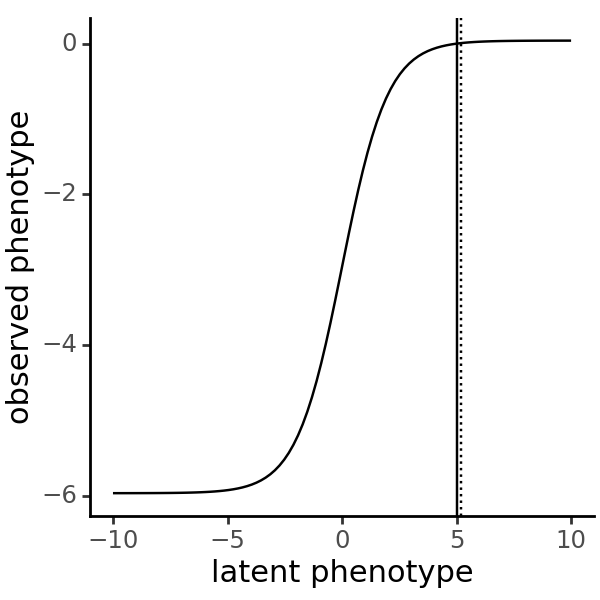

In [21]:
resolution = (-10, 10, 100)
p = (
    ggplot(
        pd.DataFrame(
            {
                "x":np.linspace(*resolution), 
                "y":np.array(list(map(g, np.linspace(*resolution))))
            }
        ), 
    )
    + geom_line(aes(x="x", y="y"))
    + geom_vline(xintercept=SigmoidPhenotype_h1.wt_latent)
    + geom_vline(xintercept=SigmoidPhenotype_h2.wt_latent, linetype="dotted")
    + labs(x="latent phenotype", y="observed phenotype")
    + theme_classic()
    + theme(figure_size=(3, 3))
)
_ = p.draw(show=True)


Next, assign each barcoded variant an _observed phenotype_, $p(v, d)$, as well as an _observed enrichment_ , $2^{p(v, d)}$. 

In [22]:
subs = CodonVariantTable_h1.barcode_variant_df['aa_substitutions']
phenotype_fxn_dict_h1["observedPhenotype"] = lambda x: g(float(phenotype_fxn_dict_h1["latentPhenotype"](x)))
CodonVariantTable_h1.barcode_variant_df['observed_phenotype'] = subs.apply(
    phenotype_fxn_dict_h1["observedPhenotype"]
)
phenotype_fxn_dict_h1["observedEnrichment"] = lambda x: 2 ** (phenotype_fxn_dict_h1["observedPhenotype"](x))
CodonVariantTable_h1.barcode_variant_df['observed_enrichment'] = subs.apply(
    phenotype_fxn_dict_h1["observedEnrichment"]
)

subs = CodonVariantTable_h2.barcode_variant_df['aa_substitutions']
phenotype_fxn_dict_h2["observedPhenotype"] = lambda x: g(float(phenotype_fxn_dict_h2["latentPhenotype"](x)))
CodonVariantTable_h2.barcode_variant_df['observed_phenotype'] = subs.apply(
    phenotype_fxn_dict_h2["observedPhenotype"]
)
phenotype_fxn_dict_h2["observedEnrichment"] = lambda x: 2 ** (phenotype_fxn_dict_h2["observedPhenotype"](x))
CodonVariantTable_h2.barcode_variant_df['observed_enrichment'] = subs.apply(
    phenotype_fxn_dict_h2["observedEnrichment"]
)
variants_df = pd.concat(
    [
        CodonVariantTable_h1.barcode_variant_df.assign(homolog="h1"), 
        CodonVariantTable_h2.barcode_variant_df.assign(homolog="h2")
    ]
)

variants_df[["aa_substitutions", "latent_phenotype", "observed_phenotype", "observed_enrichment", "homolog"]].head()

aa_substitutions  latent_phenotype  \
0  V24Q S25R H27P D29L H33C S41L C44F S47F        -11.096139   
1                       V8P H27T P30* L49P        -11.106200   
2                                V19P V43Q         -2.878203   
3                                     R20Y          5.161623   
4                                                   5.000000   

   observed_phenotype  observed_enrichment homolog  
0           -5.959752             0.016067      h1  
1           -5.959753             0.016067      h1  
2           -5.640393             0.020048      h1  
3            0.005959             1.004139      h1  
4            0.000000             1.000000      h1

Note that the post-selection counts we simulate below for a given variant are pulled from a multinomial distribution with probabilities proportional to the observed enrichment. Let's plot the observed enrichment as a function of the latent phenotype 

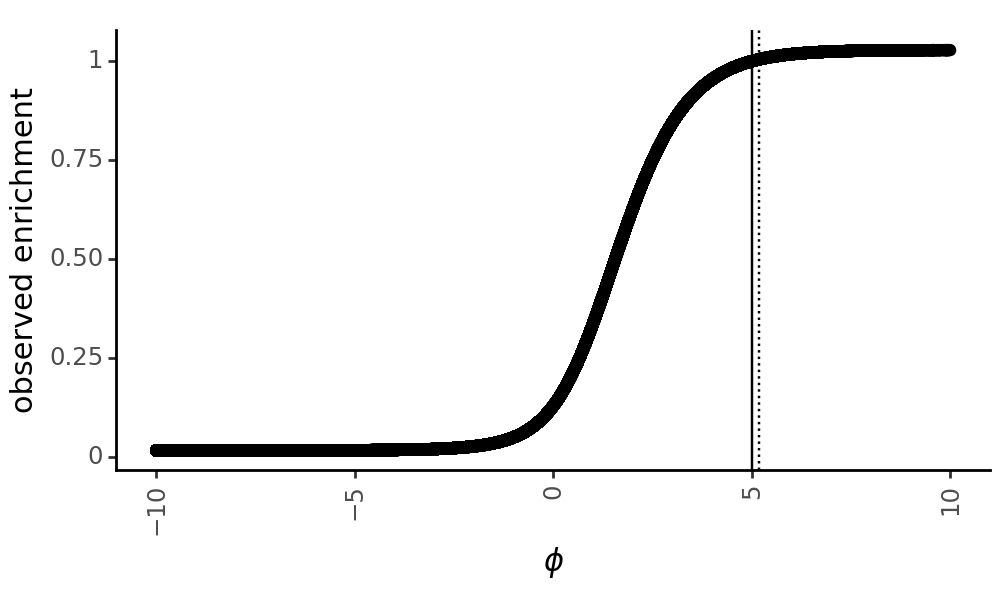

In [23]:

p = (
    ggplot(
        variants_df, 
        aes(
            x = "latent_phenotype",
            y = "observed_enrichment"
        )
    )
    + geom_point()
    + geom_vline(xintercept=SigmoidPhenotype_h1.wt_latent)
    + geom_vline(xintercept=SigmoidPhenotype_h2.wt_latent, linetype="dotted")
    + theme_classic()
    + theme(
        figure_size=(5, 3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    # + scale_fill_manual(values=CBPALETTE[1:], guide=False)
    + labs(
        x="$\phi$",
        y="observed enrichment"
    )
    # zoom in on the x axis limits
    + scale_x_continuous(limits=(-10, 10))
)
_ = p.draw(show=True)

### Pre and post-selection variant read counts

Next, we would like to simulate both pre and post-selection counts of each variant in each experiment in proportion to their ground-truth `"observed_enrichment"`. Post selection counts will be simulated by applying the specified selection bottleneck(s), to the pre-selection counts. To do this, we will use the `simulate_counts` function from `dms_variants.simulate` and the `compute_scores` function from `dms_variants.codonvarianttable`.

In [24]:
# do this independently for each of the homologs.
counts_h1, counts_h2 = [
    dms_variants.simulate.simulateSampleCounts(
        variants=variants,
        phenotype_func=pheno_fxn_dict["observedEnrichment"],
        variant_error_rate=variant_error_rate,
        pre_sample={
            "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
            "uniformity": lib_uniformity,
        },
        pre_sample_name="pre-selection",
        post_samples={
            name: {
                "noise": noise,
                "total_count": variants_per_lib * np.random.poisson(avgdepth_per_variant),
                "bottleneck": bottleneck,
            }
            for name, bottleneck in bottlenecks.items()
        },
        seed=seed,
    )
    for variants, pheno_fxn_dict in zip(
        [CodonVariantTable_h1, CodonVariantTable_h2], [phenotype_fxn_dict_h1, phenotype_fxn_dict_h2]
    )
]
CodonVariantTable_h1.add_sample_counts_df(counts_h1)
CodonVariantTable_h2.add_sample_counts_df(counts_h2)

Plot the number of counts for each variant in each sample. The horizontal dashed line shows the total number of variants. The plot shows that all variants are well-sampled in the pre-selection libraries, but that post- selection some variants are sampled more or less. This is expected since selection will decrease and increase the frequency of variants:

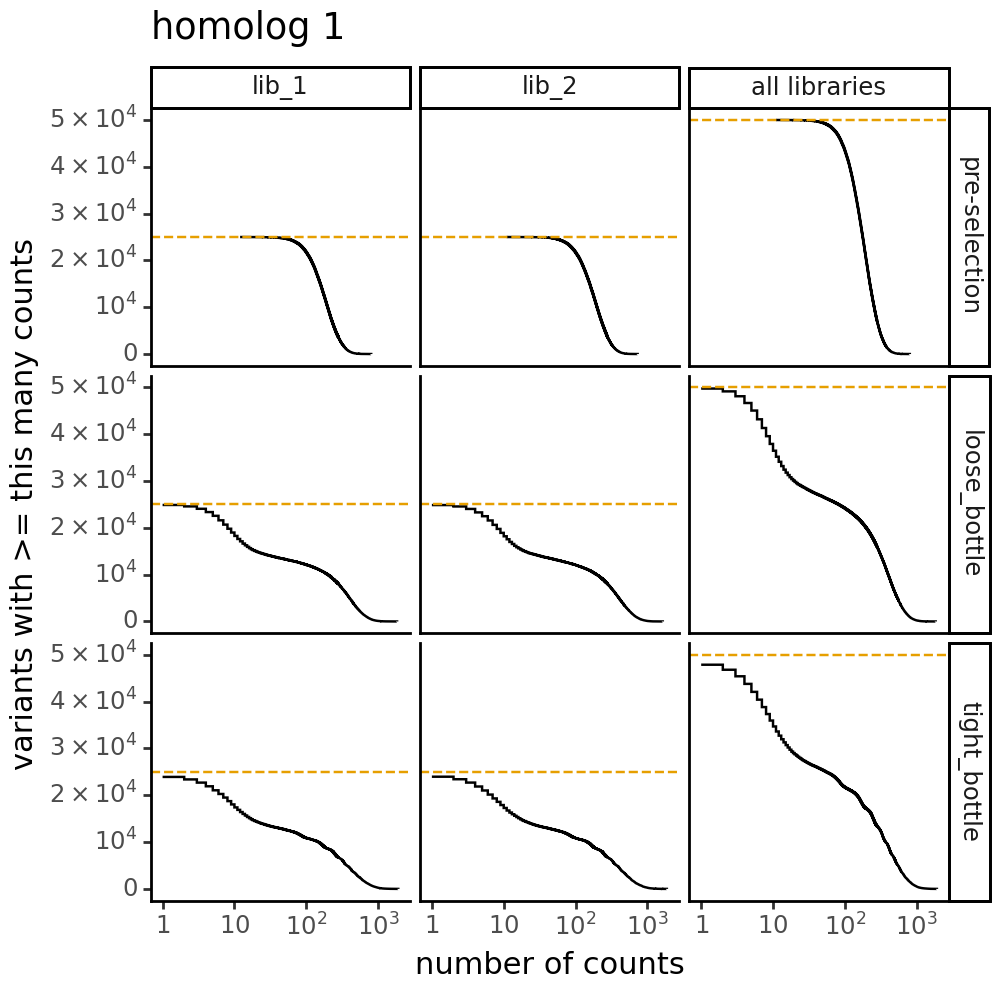

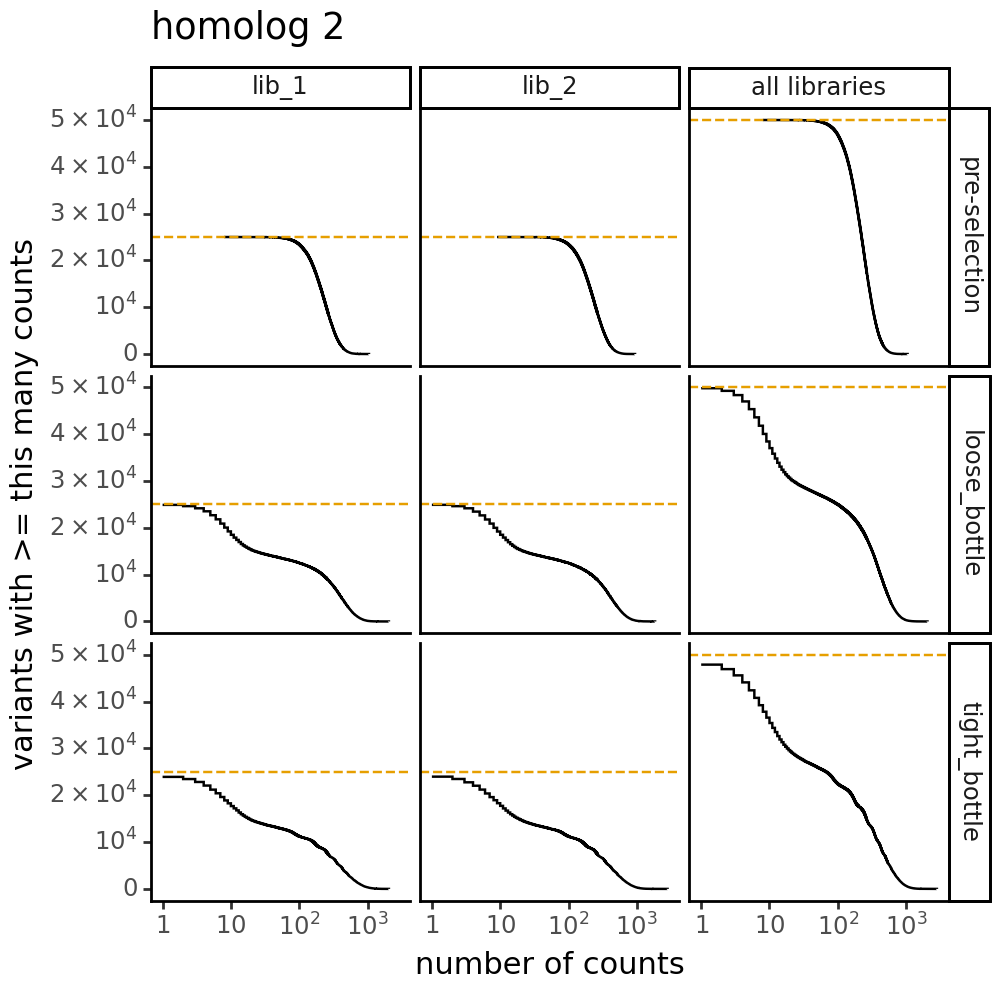

In [25]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotCumulVariantCounts()
    p += theme_classic() 
    p += theme(
        panel_grid_major_x=element_blank(),  # no vertical grid lines
        figure_size=(5, 5)
    )
    p += labs(title=title)
    # plt.tight_layout()
    _ = p.draw(show=True)

Distribution of the number of amino-acid mutations per variant in each sample. As expected, mutations go down after selection:

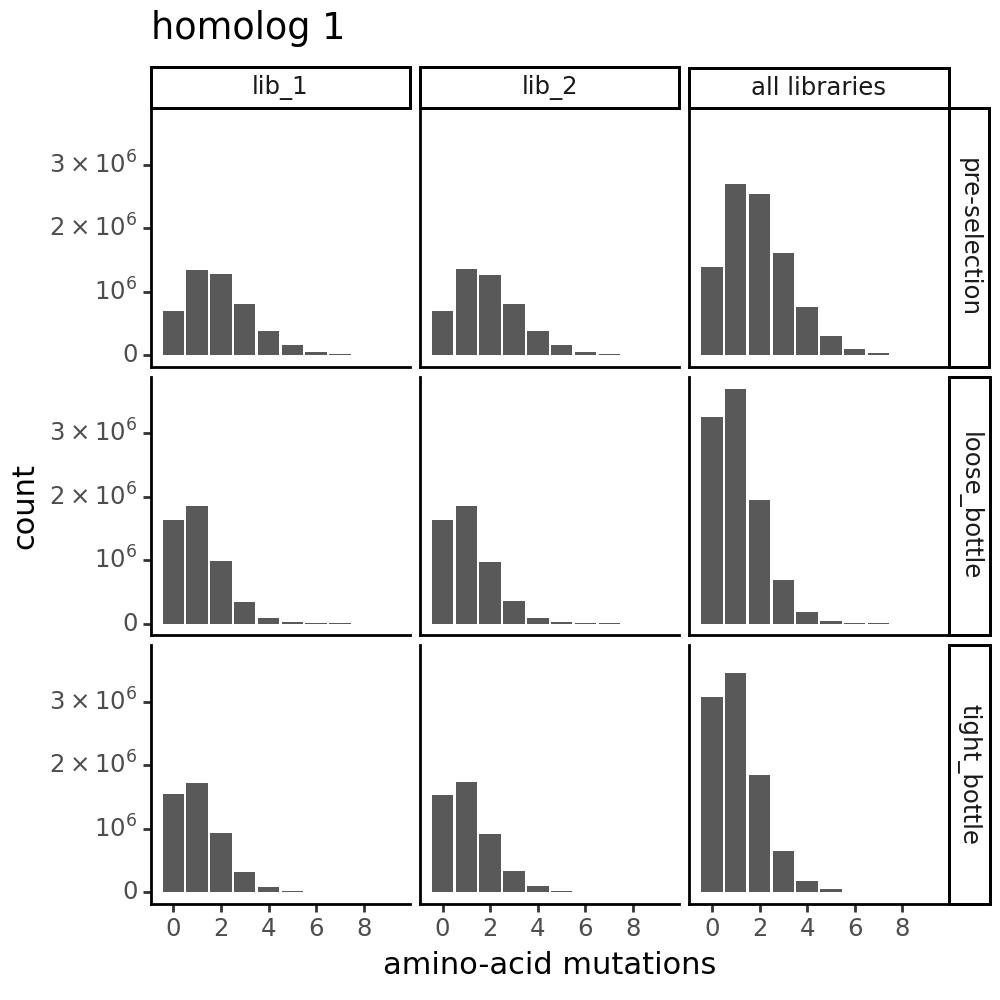

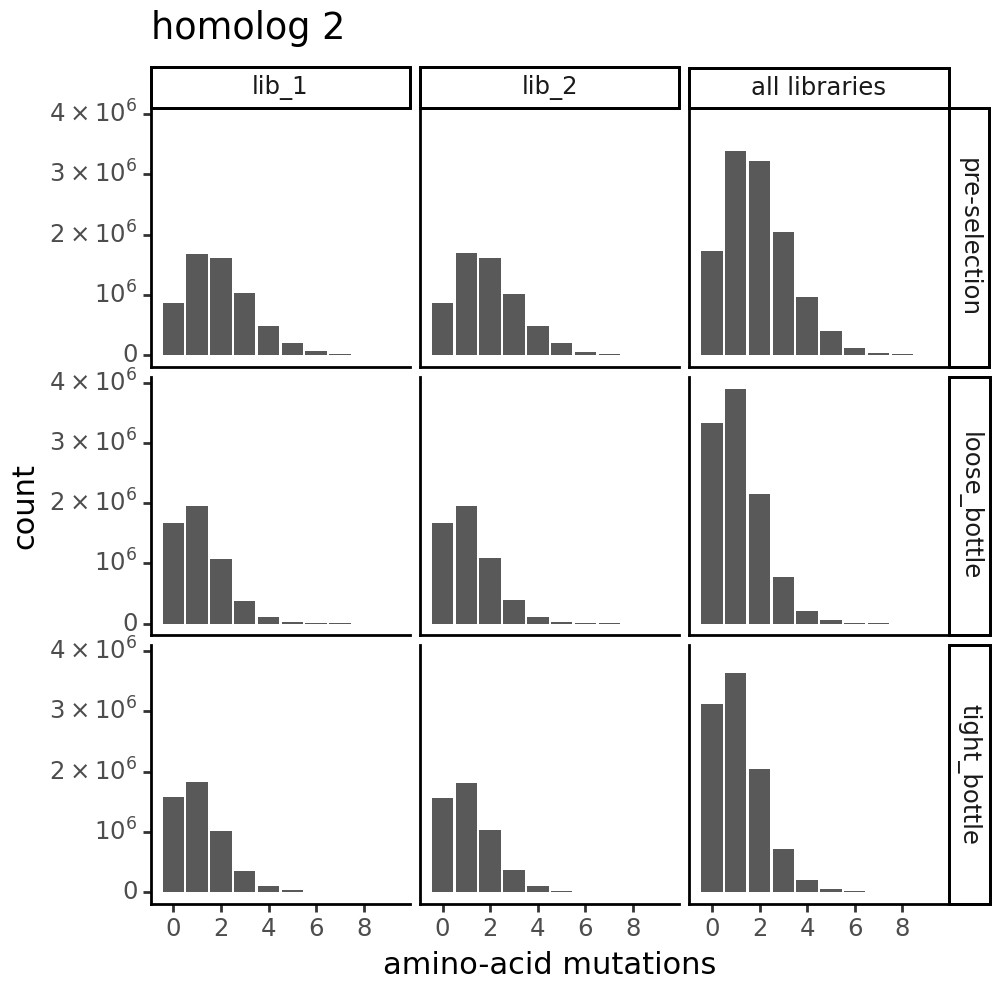

In [26]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotNumMutsHistogram(mut_type="aa")
    p += theme_classic() 
    p += theme(
        panel_grid_major_x=element_blank(),  # no vertical grid lines
        figure_size=(5, 5)
    )
    p += labs(title=title)
    _ = p.draw(show=True)

Plot how thoroughly amino-acid mutations are sampled. The plots below show that the stop mutations are sampled very poorly post-selection because they are eliminated during selection:

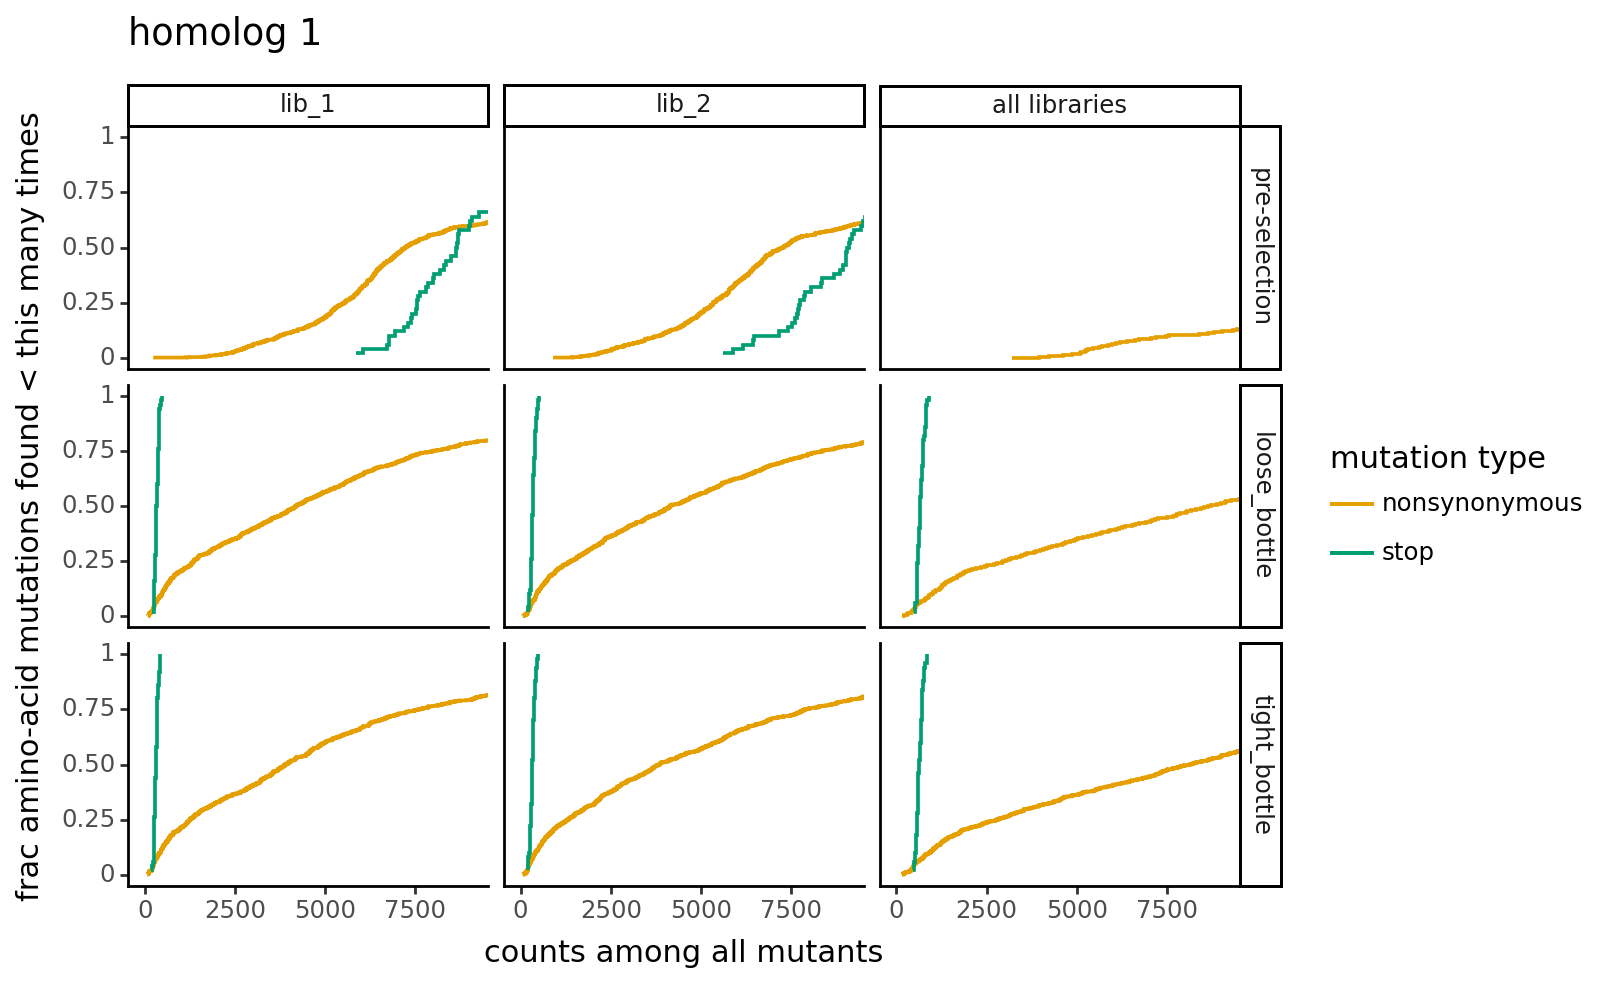

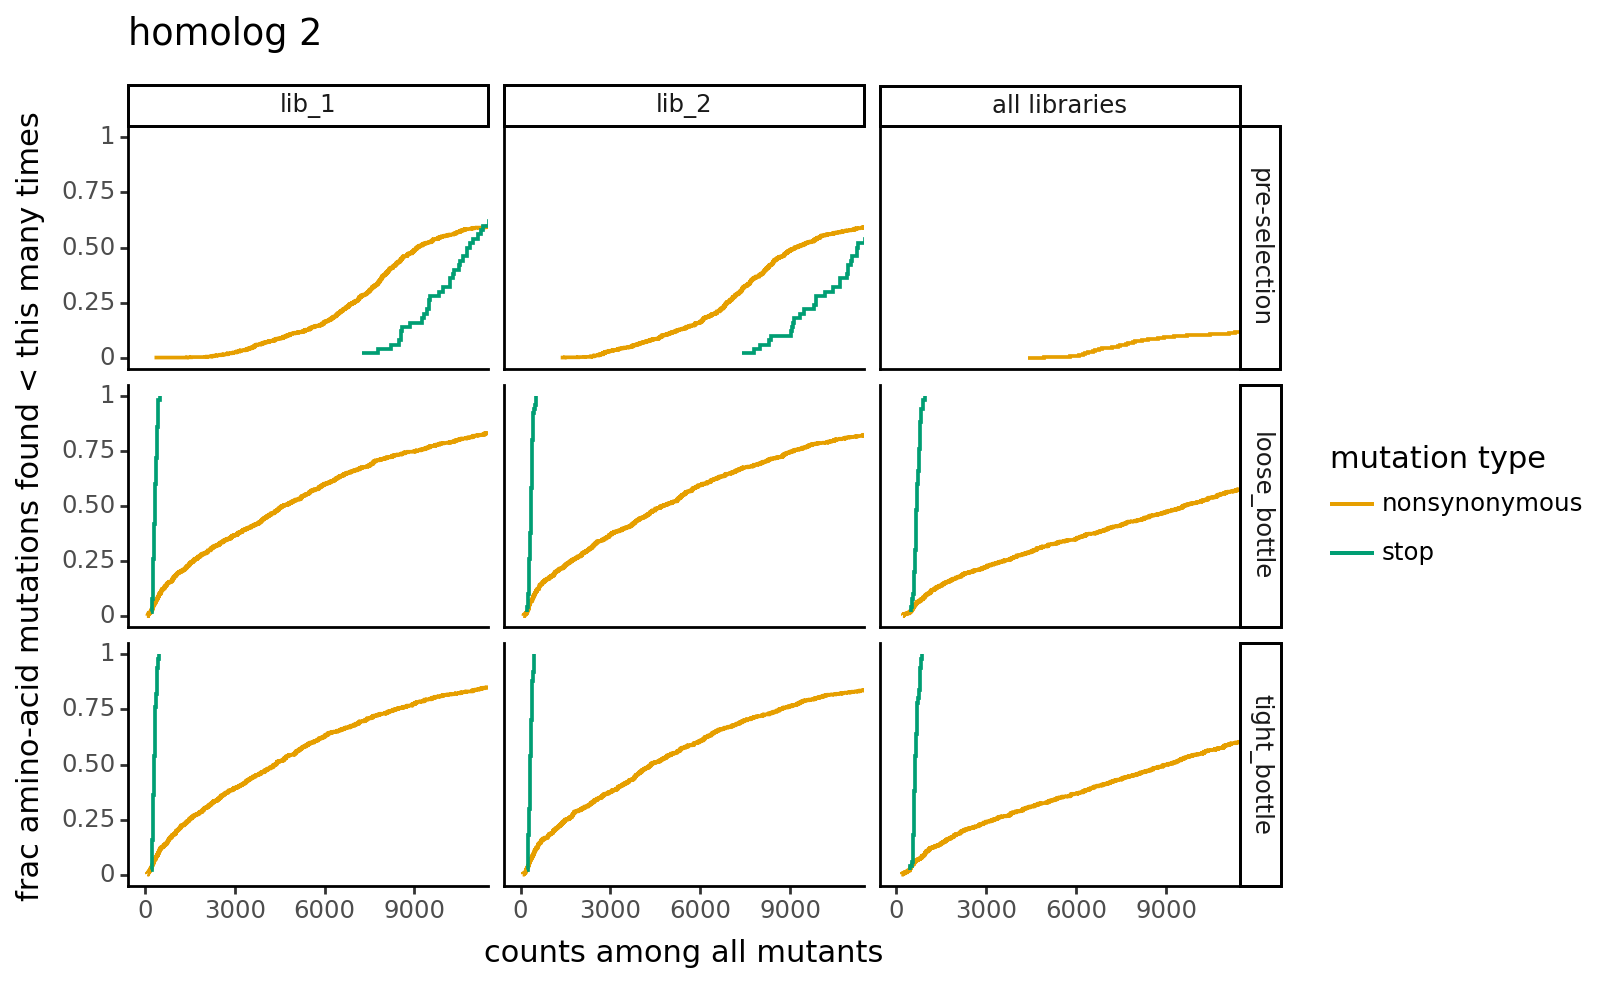

In [27]:
for variants, title in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['homolog 1', 'homolog 2']):
    p = variants.plotCumulMutCoverage(variant_type="all", mut_type="aa")
    p += theme_classic() 
    p += theme(
        # panel_grid_major_x=element_blank(),  # no vertical grid lines
        figure_size=(8, 5)
    )
    p += labs(title=title)
    _ = p.draw(show=True)

## `multidms` Fitting

### Prep training data

Prepare the training dataframes for fitting our joint `multidms` models.  As this is a joint-fitting approach, we combine homolog variants from each of the corresponding library replicates into a single training dataset. 
Additionally, for each replicate dataset, we'll train models on each of the following targets representing different levels of noise in the data:

1. Ground truth _observed phenotype_ - this target acts as a control and benchmarks the ability of the model to recover the true latent effects and shifts controlling for other sources of noise.
2. _Loose bottleneck_ counts derived functional scores - these scores are derived from the observed enrichments, and used to asses model performance in the context of realistic experimental noise.
3. _Tight bottleneck_ counts derived functional scores - the same as above, but with a tighter bottleneck for more extreme cases of noise.

For further details on how to prepare data and fit models, see the `multidms` [quick-start tutorial](https://matsengrp.github.io/multidms/fit_delta_BA1_example.html).



Start by creating training data with ground truth phenotype target. Because the barcode replicates share ground truth phenotypes we can can collapse the counts accross replicates by simple dropping duplicates. define the required columns and their order

In [28]:
req_cols = ["library", "condition", "aa_substitutions", "func_score_type", "func_score"]
ground_truth_training_set = (
    pd.concat(
        [
            variants.barcode_variant_df[["library", "aa_substitutions", "observed_phenotype"]]
            .drop_duplicates()
            .assign(condition=homolog)
            for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
        ]
    )
    .melt(
        id_vars=["library", "aa_substitutions", "condition"],
        value_vars=["observed_phenotype"],
        var_name="func_score_type",
        value_name="func_score",
    )
    [req_cols]
    .astype({c:str for c in req_cols[:-1]})
)
ground_truth_training_set.head()

library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

      func_score_type  func_score  
0  observed_phenotype   -5.959752  
1  observed_phenotype   -5.959753  
2  observed_phenotype   -5.640393  
3  observed_phenotype    0.005959  
4  observed_phenotype    0.000000

Next, compute functional scores from pre-post counts in each bottleneck _after_ aggregating the barcode replicate counts for unique variants. The `dms_variants.CodonVariantTable.func_scores` [method](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores) provides the ability to compute functional scores from pre and post-selection counts. We'll use this to compute functional scores for each of the three targets:

In [29]:
# Collapsing counts accross replicate `aa_substituitions` _before_ computing the functional score.
bottle_cbf = pd.concat(
    [
        (
            variants
            .func_scores("pre-selection", by="aa_substitutions", libraries=libs, syn_as_wt=True)
            .assign(condition=homolog)
            .rename({"post_sample":"func_score_type"}, axis=1)
            [req_cols]
            .astype({c:str for c in req_cols[:-1]})
        )
        for variants, homolog in zip([CodonVariantTable_h1, CodonVariantTable_h2], ['h1', 'h2'])
    ]
)
bottle_cbf.head()

library condition aa_substitutions func_score_type  func_score
0   lib_1        h1             Q28P    loose_bottle   -0.021369
1   lib_1        h1             G50E    loose_bottle   -0.067491
2   lib_1        h1             R48G    loose_bottle   -1.291522
3   lib_1        h1    S3R G10Y L49H    loose_bottle   -5.759732
4   lib_1        h1   F18T Q21E C44T    loose_bottle   -5.313711

Finally, combine the two dataframes computed above, and classify the variants based on the number of amino acid substitutions.

In [30]:

def classify_variant(aa_subs):
    if "*" in aa_subs:
        return "stop"
    elif aa_subs == "":
        return "wildtype"
    elif len(aa_subs.split()) == 1:
        return "1 nonsynonymous"
    elif len(aa_subs.split()) > 1:
        return ">1 nonsynonymous"
    else:
        raise ValueError(f"unexpected aa_subs: {aa_subs}")

func_scores = (
    pd.concat([ground_truth_training_set, bottle_cbf])
    .assign(variant_class = lambda x: x['aa_substitutions'].apply(classify_variant))
)

func_scores.head()

library condition                         aa_substitutions  \
0   lib_1        h1  V24Q S25R H27P D29L H33C S41L C44F S47F   
1   lib_1        h1                       V8P H27T P30* L49P   
2   lib_1        h1                                V19P V43Q   
3   lib_1        h1                                     R20Y   
4   lib_1        h1                                            

      func_score_type  func_score     variant_class  
0  observed_phenotype   -5.959752  >1 nonsynonymous  
1  observed_phenotype   -5.959753              stop  
2  observed_phenotype   -5.640393  >1 nonsynonymous  
3  observed_phenotype    0.005959   1 nonsynonymous  
4  observed_phenotype    0.000000          wildtype

Plot a pairplot to see how targets compare.

In [31]:
fig = sns.pairplot(
    (
        func_scores
        .pivot(
            index=["library", "condition", "aa_substitutions", "variant_class"],
            columns="func_score_type",
            values="func_score"
        )
        .reset_index()
        .sample(frac=0.1)
    ),  
    hue='condition',
    plot_kws = {"alpha":0.25},
    corner=True
)
plt.tight_layout()
plt.show()

Plot the functional scores distributions of the bottleneck counts-computed functional scores. Recall that we collapsed barcode replicates so there is only a single wildtype phenotype in each of the datasets, thus we will not plot them below.

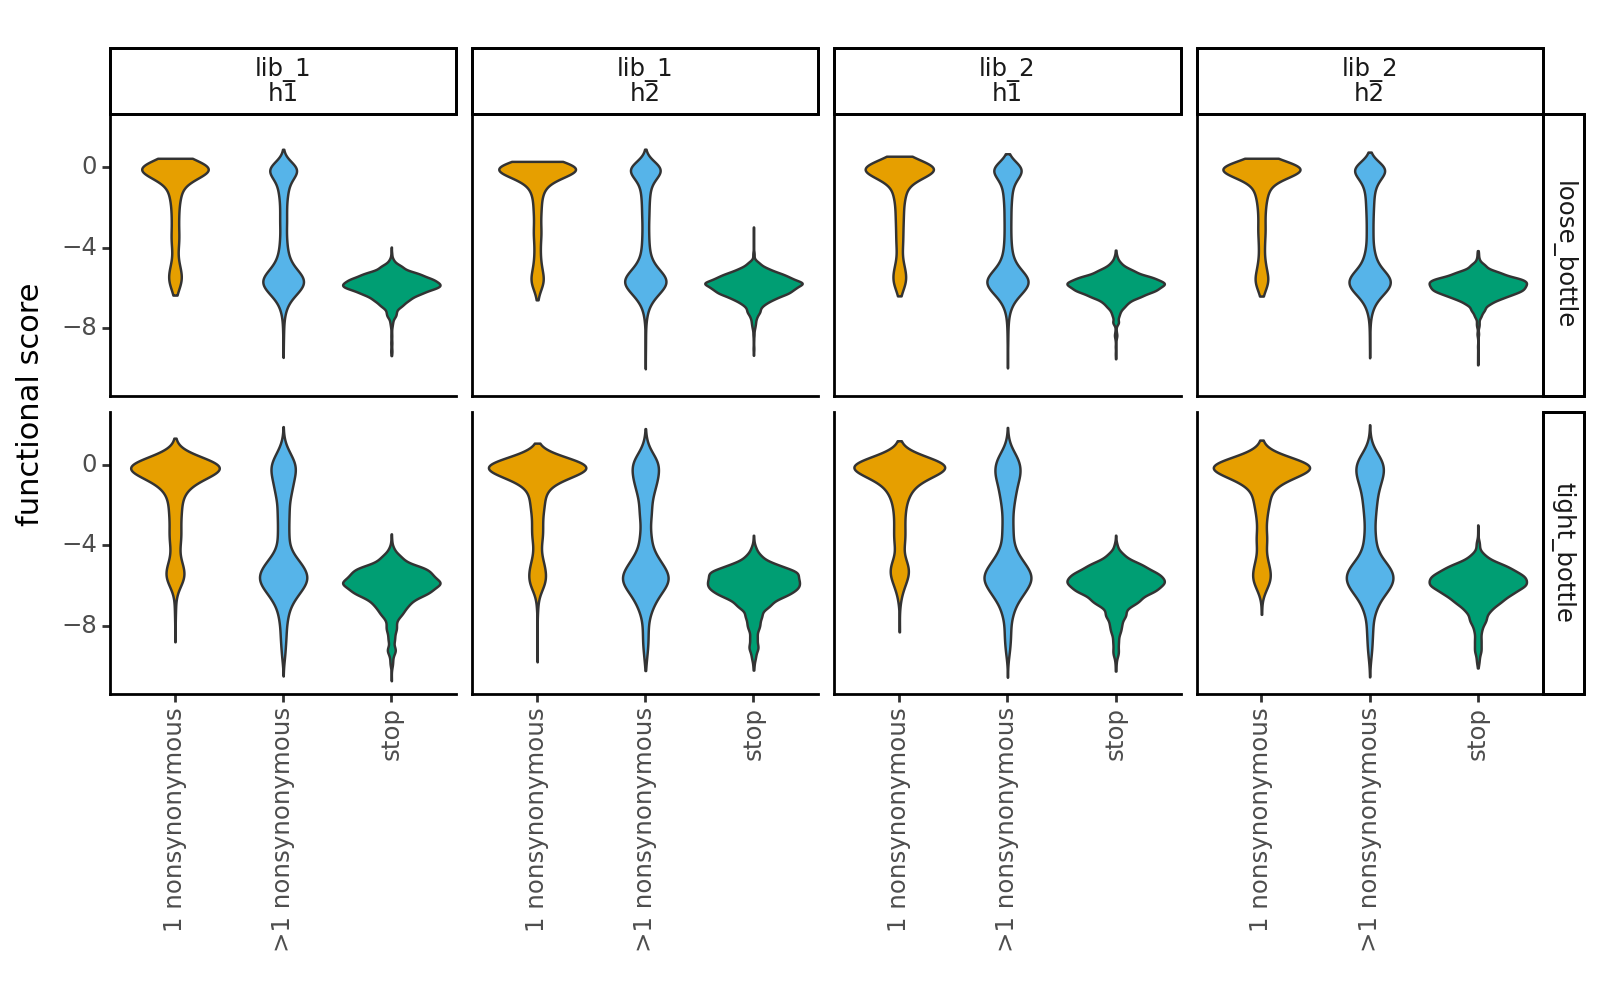

In [69]:
p = (
    ggplot(
        func_scores.query("(func_score_type != 'observed_phenotype') & (variant_class != 'wildtype')"), 
        aes("variant_class", "func_score")
    )
    + geom_violin(aes(fill="variant_class"))
    + ylab("functional score")
    + xlab("")
    + facet_grid("func_score_type ~ library + condition")
    + theme_classic()
    + theme(
        figure_size=(8, 5),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + scale_fill_manual(values=CBPALETTE[1:], guide=False)
)
_ = p.draw(show=True)

### Create `Data` objects for each library replicate, and bottleneck

`multidms` model fitting is generally a two-step process: (1) Create `Data` objects from functional score dataframes which, among other things, encode the variant data into one-hot encoded matrices, and (2) fit a collection of models across a grid of `Data` objects and hyperparameters. Here, we'll create `Data` objects for each library replicate / fitting target combination:

In [33]:
data_objects = [
    multidms.Data(
        fs_df, 
        reference="h1", 
        alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
        verbose=False,
        name = f"{lib}_{target}_func_score"
    )
    for (lib, target), fs_df in func_scores.groupby(['library', 'func_score_type'])
]

data_objects

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[Data(lib_1_loose_bottle_func_score),
 Data(lib_1_observed_phenotype_func_score),
 Data(lib_1_tight_bottle_func_score),
 Data(lib_2_loose_bottle_func_score),
 Data(lib_2_observed_phenotype_func_score),
 Data(lib_2_tight_bottle_func_score)]

### Fit models to training data (lasso sweep)

Next, we'll fit a set of models to each of the datasets defined above using the `multidms.fit_models` [function](https://matsengrp.github.io/multidms/multidms.model_collection.html#multidms.model_collection.fit_models). For each dataset, we independently fit models with a number of different lasso penalty coefficients ($\lambda_{L1}$) as defined at the top of this notebook. 

In [34]:
fitting_params["dataset"] = data_objects
pprint.pprint(fitting_params)

{'dataset': [Data(lib_1_loose_bottle_func_score),
             Data(lib_1_observed_phenotype_func_score),
             Data(lib_1_tight_bottle_func_score),
             Data(lib_2_loose_bottle_func_score),
             Data(lib_2_observed_phenotype_func_score),
             Data(lib_2_tight_bottle_func_score)],
 'init_beta_naught': [5.0],
 'iterations_per_step': [10000],
 'scale_coeff_lasso_shift': [0.0, 1e-05, 2e-05, 5e-05, 0.0001, 0.0002, 0.001],
 'scale_coeff_ridge_beta': [0.0]}


Fit the models:

In [35]:
_, _, fit_collection_df = multidms.model_collection.fit_models(fitting_params)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 


Note that the return type of `multidms.fit_models` is a `tuple(int, int, pd.DataFrame)` where the first two values are the number of fits that were successful and the number that failed, respectively, and the third value is a dataframe where each row contains a fit `Model` object and the hyperparameters used to fit it.

In [36]:
fit_collection_df[["model", "dataset_name", "scale_coeff_lasso_shift"]].head()

model                   dataset_name scale_coeff_lasso_shift
0  Model(Model-0)  lib_1_loose_bottle_func_score                     0.0
1  Model(Model-0)  lib_1_loose_bottle_func_score                 0.00001
2  Model(Model-0)  lib_1_loose_bottle_func_score                 0.00002
3  Model(Model-0)  lib_1_loose_bottle_func_score                 0.00005
4  Model(Model-0)  lib_1_loose_bottle_func_score                  0.0001

Add a few helpful features to this dataframe for plotting by splitting the "dataset_name" (name of the Data Object that was used for fitting) into more understandable columns:

In [37]:
fit_collection_df = fit_collection_df.assign(
    measurement_type = fit_collection_df["dataset_name"].str.split("_").str[2:4].str.join("_"),
    library = fit_collection_df["dataset_name"].str.split("_").str[0:2].str.join("_")
)

# convert measurement type to categorical ordered by 'observed', 'loose', 'tight' for plotting
fit_collection_df["measurement_type"] = pd.Categorical(
    fit_collection_df["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

fit_collection_df[["model", "measurement_type", "library", "scale_coeff_lasso_shift"]].head()

model measurement_type library scale_coeff_lasso_shift
0  Model(Model-0)     loose_bottle   lib_1                     0.0
1  Model(Model-0)     loose_bottle   lib_1                 0.00001
2  Model(Model-0)     loose_bottle   lib_1                 0.00002
3  Model(Model-0)     loose_bottle   lib_1                 0.00005
4  Model(Model-0)     loose_bottle   lib_1                  0.0001

## Model selection

### Model vs. truth mutational effects

The `multidms.ModelCollection` takes a a dataframe such as the one created above and provides a few helpful methods for model selection and aggregation. We'll use these methods to evaluate the fits and select the best model for each dataset.

In [38]:
model_collection = multidms.model_collection.ModelCollection(fit_collection_df)

Get the mutational parameters for each of the models using `model_collection.split_apply_combine_muts()` [method](https://matsengrp.github.io/multidms/multidms.model_collection.html#multidms.model_collection.ModelCollection.split_apply_combine_muts), and merge them with the simulated ground truth parameters:

In [39]:
# the columns that distinguish fits are what we'll groupby such that none of the model collection parameters are aggregated
groupby=("library", "measurement_type", "scale_coeff_lasso_shift")
collection_muts_df = (
    model_collection.split_apply_combine_muts(
        groupby=groupby
    )
    .reset_index()
    .rename(
        {
            'beta' : 'predicted_beta',
            'shift_h2' : 'predicted_shift_h2',
        }, 
        axis=1
    )    
    .merge(
        mut_effects_df.rename(
            {
                'beta_h1' : 'true_beta',
                'beta_h2' : 'true_beta_h2',
                'shift' : 'true_shift',
            },
            axis=1
        ),
        on='mutation'
    )
)
assert collection_muts_df.shape[0] == len(mut_effects_df) * len(fit_collection_df)
collection_muts_df[["mutation", "library", "measurement_type", "scale_coeff_lasso_shift", "predicted_shift_h2", "true_shift"]].head()

cache miss - this could take a moment


mutation library    measurement_type  scale_coeff_lasso_shift  \
0     C31*   lib_1  observed_phenotype                  0.00000   
1     C31*   lib_1  observed_phenotype                  0.00001   
2     C31*   lib_1  observed_phenotype                  0.00002   
3     C31*   lib_1  observed_phenotype                  0.00005   
4     C31*   lib_1  observed_phenotype                  0.00010   

   predicted_shift_h2  true_shift  
0           -5.268372         0.0  
1            0.183935         0.0  
2            0.057728         0.0  
3            0.000000         0.0  
4            0.000000         0.0

To compare model fits parameter values to the simulated ground truth values, add mean squared error and pearsonr metrics to the `ModelCollection.fit_models` attribute:

In [40]:
def series_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

def series_mae(y_true, y_pred):
    return np.mean(y_true - y_pred)

# compute the new metric columns
new_fit_models_cols = defaultdict(list)
for group, model_mutations_df in collection_muts_df.groupby(list(groupby)):
    # add cols for merging
    for i, attribute in enumerate(group):
        new_fit_models_cols[groupby[i]].append(group[i])
        
    for parameter in ["beta", "shift"]:
        for metric_fxn, name in zip([series_corr, series_mae], ["corr", "mae"]):

            # add the new metric columns
            postfix="_h2" if parameter == "shift" else ""
            y_pred = model_mutations_df[f"predicted_{parameter}{postfix}"]
            y_true = model_mutations_df[f"true_{parameter}"]
            new_fit_models_cols[f"{parameter}_{name}"].append(metric_fxn(y_true, y_pred))

# merge the new columns into the model collection
model_collection.fit_models = model_collection.fit_models.merge(
    pd.DataFrame(new_fit_models_cols),
    on=list(groupby)
)

# print the first few rows of the model collection
model_collection.fit_models[list(groupby) + [c for c in new_fit_models_cols.keys() if c not in groupby]].head()


library measurement_type scale_coeff_lasso_shift  beta_corr  beta_mae  \
0   lib_1     loose_bottle                     0.0   0.974906 -0.080003   
1   lib_1     loose_bottle                 0.00001   0.975240 -0.051355   
2   lib_1     loose_bottle                 0.00002   0.977106 -0.010785   
3   lib_1     loose_bottle                 0.00005   0.978330 -0.028096   
4   lib_1     loose_bottle                  0.0001   0.976815 -0.046090   

   shift_corr  shift_mae  
0    0.316704   0.328474  
1    0.880102   0.007951  
2    0.940989   0.005402  
3    0.930509   0.006165  
4    0.906519   0.005982

Next, we'll make some summary plots with the predicted vs. simulated ground MSE truth parameters across model fits

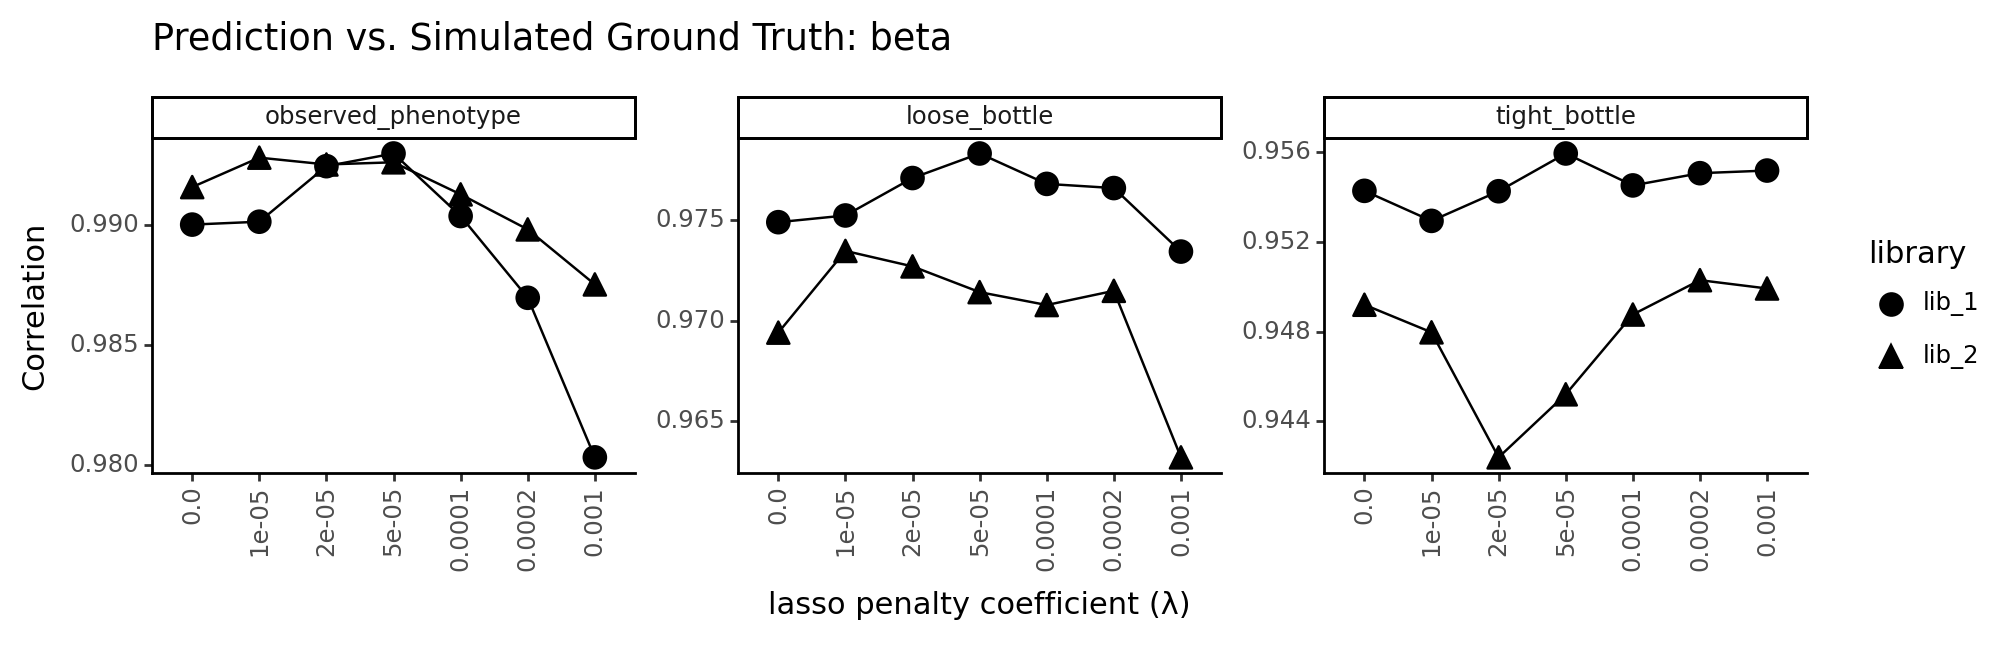

In [41]:
metric = "corr"

data = (
    model_collection.fit_models
    .assign(
        measurement_library = lambda x: x["measurement_type"].astype(str) + " " + x["library"]
    )
    .melt(
        id_vars=list(groupby) + ["measurement_library"],
        value_vars=[f"beta_{metric}", f"shift_{metric}"],
        var_name="parameter",
        value_name=metric,
    )
)
data["measurement_type"] = pd.Categorical(
    data["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
data["parameter"] = data["parameter"].str.replace(f"_{metric}", "")
data["parameter"] = pd.Categorical(
    data["parameter"],
    categories=["shift", "beta"],
    ordered=True
)
for parameter, parameter_df in data.groupby("parameter", observed=True):
    p = (
        ggplot(parameter_df)
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y=metric,
                group="measurement_library",
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y=metric,
                shape="library"
            ),
            size=4
        )
        + facet_wrap("measurement_type", scales="free_y")
        + theme_classic()
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Prediction vs. Simulated Ground Truth: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="Mean Absolute Error" if metric == "mae" else "Correlation"
        )
    )
    _ = p.draw(show=True)

### Shift sparsity

Another way we might evaluate the fits is by looking at the _sparsity_ of the models by computing the percentage of shift parameters that are equal to zero among the models. We look at this metric separately for mutations to stop codons and mutations to non-stop codons because we expect the stop codons to be equally deleterious in both homologs, and thus we expect all the shift parameters associated with stop codon mutations to be zero in a "good" fit.

In [71]:
chart, data = model_collection.shift_sparsity(return_data=True)
data.head()

dataset_name  scale_coeff_lasso_shift       mut_type  \
0  lib_1_loose_bottle_func_score                  0.00000  nonsynonymous   
1  lib_1_loose_bottle_func_score                  0.00000           stop   
2  lib_1_loose_bottle_func_score                  0.00001  nonsynonymous   
3  lib_1_loose_bottle_func_score                  0.00001           stop   
4  lib_1_loose_bottle_func_score                  0.00002  nonsynonymous   

  mut_param  sparsity  
0  shift_h2  0.000000  
1  shift_h2  0.000000  
2  shift_h2  0.107368  
3  shift_h2  0.000000  
4  shift_h2  0.269474

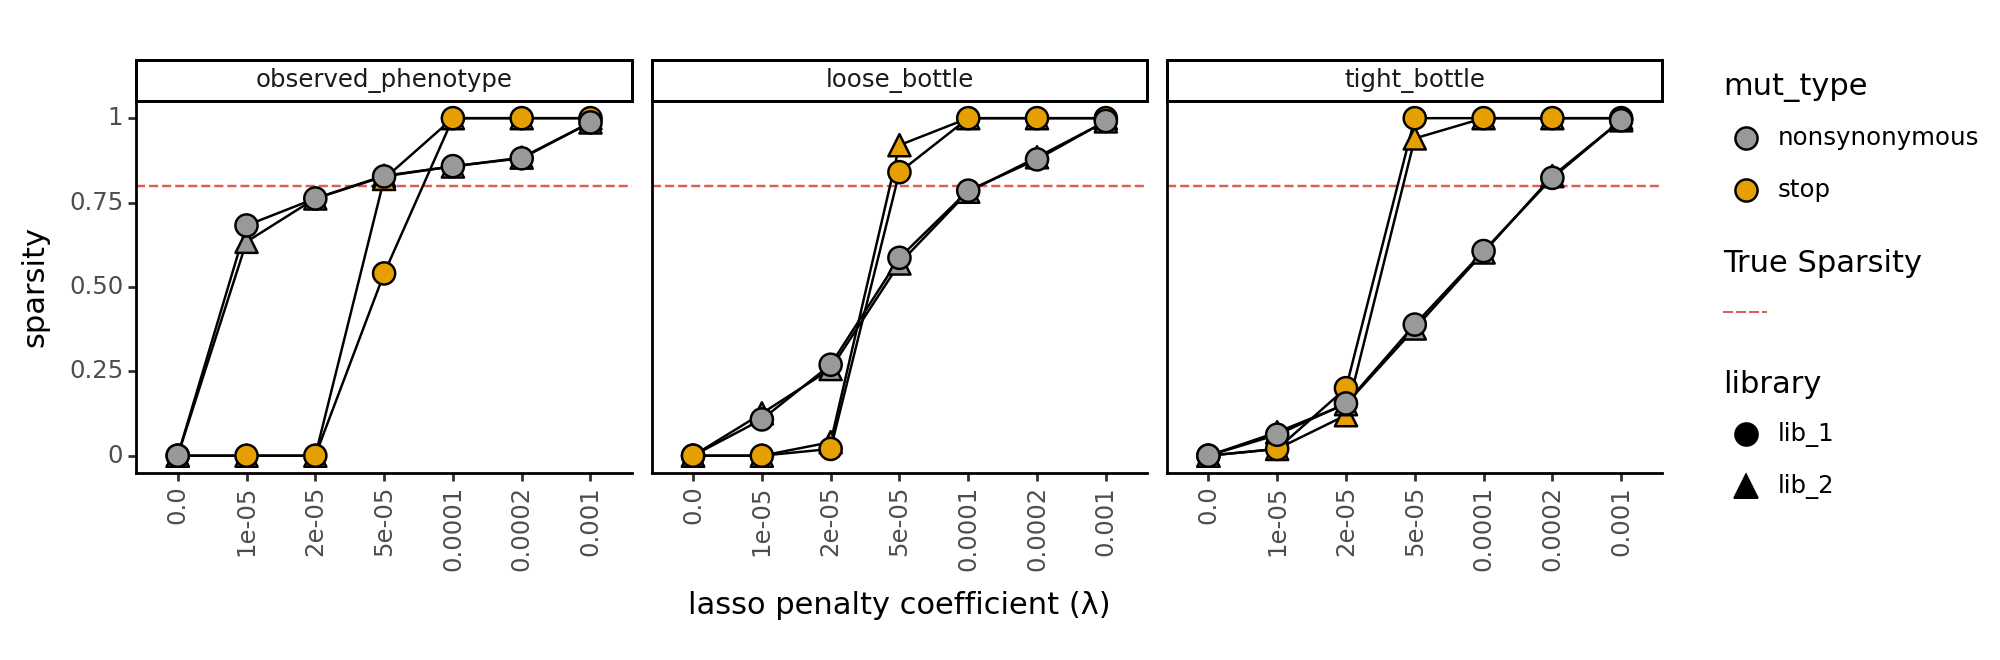

In [72]:
data =data.assign(
    library=data.dataset_name.str.split("_").str[:2].str.join("_"),
    library_type = data.dataset_name.str.split("_").str[:2].str.join("_") + "-" + data.mut_type,
    measurement_type = data.dataset_name.str.split("_").str[2:4].str.join("_")
)
# convert measurement type to categorical ordered by 'observed', 'loose', 'tight'
data["measurement_type"] = pd.Categorical(
    data["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
data['True Sparsity'] = '' #dummy col for plotting legend
data.sort_values("scale_coeff_lasso_shift", inplace=True)
data["scale_coeff_lasso_shift"] = data.scale_coeff_lasso_shift.astype(object)

true_sparsity = 1 - mut_effects_df.shifted_site.mean()

p = (
    ggplot(
        data,
        aes("scale_coeff_lasso_shift", "sparsity")
    )
    + geom_hline(aes(yintercept=true_sparsity, color="True Sparsity"), linetype="dashed")
    + geom_line(
        aes(
            group="library_type",
        ),
    )
    + geom_point(
        aes(
            fill="mut_type",
            shape="library"
        ),
        size=4
    )
    + scale_fill_manual(values=CBPALETTE)
    + facet_wrap("measurement_type")
    + theme_classic()
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        title=f"",
        x="lasso penalty coefficient (λ)",
        y="sparsity"
    )
)
_ = p.draw(show=True)

### Replicate correlations

Another common metric to look at when evaluating models is to look at the correlation of the inferred mutational effects between the two libraries. We can do this by computing the pearson correlation coefficient between the inferred mutational effects for each mutation in the two libraries using the `multidms.ModelCollection.mut_param_dataset_correlation` [method](https://matsengrp.github.io/multidms/multidms.model_collection.html#multidms.model_collection.ModelCollection.mut_param_dataset_correlation).

In [44]:
# HERE
chart, data = model_collection.mut_param_dataset_correlation(return_data=True)
data.head()

datasets mut_param  correlation  \
0  lib_1_loose_bottle_func_score,lib_1_observed_p...      beta     0.981243   
0  lib_1_loose_bottle_func_score,lib_1_observed_p...      beta     0.979312   
0  lib_1_loose_bottle_func_score,lib_1_observed_p...      beta     0.985258   
0  lib_1_loose_bottle_func_score,lib_1_observed_p...      beta     0.986170   
0  lib_1_loose_bottle_func_score,lib_1_observed_p...      beta     0.984706   

   scale_coeff_lasso_shift  
0                  0.00000  
0                  0.00001  
0                  0.00002  
0                  0.00005  
0                  0.00010

By default, the method returns a dataframe giving parameter between each unique pair of datasets, meaning it includes correlations between models fit on different measurement types. We'll only be comparing models trained the same fitting target combination.

In [45]:
data = (
    data
    .assign(
        lib1 = data.datasets.str.split(",").str[0],
        lib2 = data.datasets.str.split(",").str[1],
        measurement_type_1 = lambda x: x["lib1"].str.split("_").str[2:4].str.join("_"),
        measurement_type_2 = lambda x: x["lib2"].str.split("_").str[2:4].str.join("_")
    )
    .query("(measurement_type_1 == measurement_type_2) & (~mut_param.str.contains('predicted_func_score'))")
    .rename(
        {
            "measurement_type_1" : "measurement_type",
        },
        axis=1
    )
    .replace({"shift_h2": "shift"})
    .drop(["lib1", "lib2", "datasets", "measurement_type_2"], axis=1)
)

data.head(10)

mut_param  correlation  scale_coeff_lasso_shift measurement_type
0      beta     0.953712                  0.00000     loose_bottle
0      beta     0.948571                  0.00001     loose_bottle
0      beta     0.950321                  0.00002     loose_bottle
0      beta     0.948969                  0.00005     loose_bottle
0      beta     0.947250                  0.00010     loose_bottle
0      beta     0.947406                  0.00020     loose_bottle
0      beta     0.935295                  0.00100     loose_bottle
0     shift     0.610553                  0.00000     loose_bottle
0     shift     0.799499                  0.00001     loose_bottle
0     shift     0.901401                  0.00002     loose_bottle

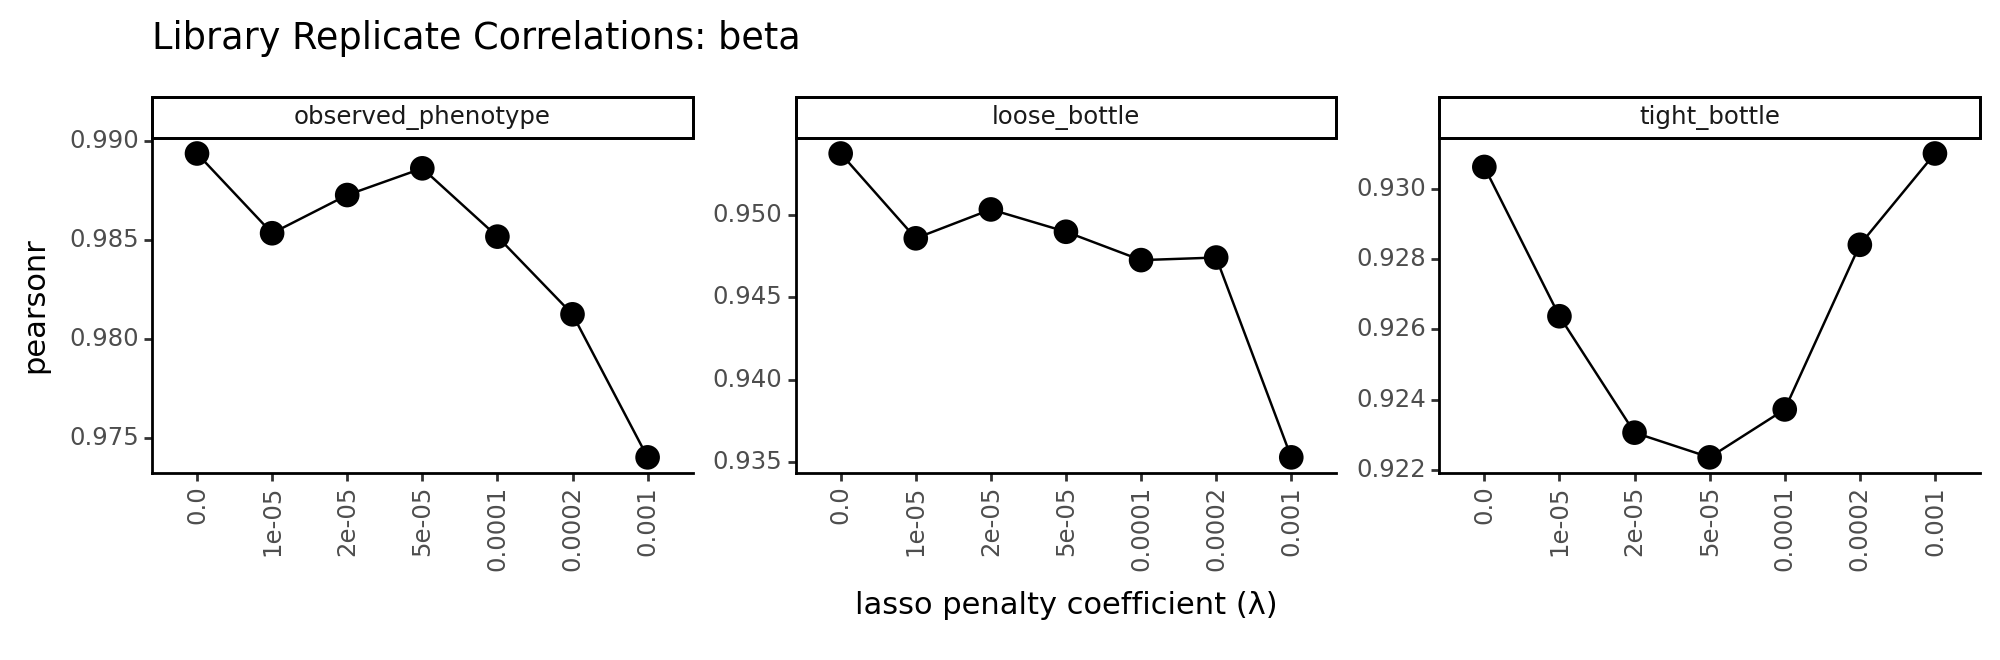

In [46]:


data["measurement_type"] = pd.Categorical(
    data["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)
data["mut_param"] = pd.Categorical(
    data["mut_param"],
    categories=["shift", "beta"],
    ordered=True
)

data["scale_coeff_lasso_shift"] = data.scale_coeff_lasso_shift.astype(object)

for parameter, parameter_df in data.groupby("mut_param", observed=True):
    p = (
        ggplot(
            parameter_df
        )
        + geom_line(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
                group="measurement_type"
            ),
        )
        + geom_point(
            aes(
                x="scale_coeff_lasso_shift",
                y="correlation",
            ),
            size=4
        )
        + facet_wrap("measurement_type", scales="free_y")
        + theme_classic()
        + theme(
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
            panel_grid_major_x=element_blank(),  # no vertical grid lines
        )
        + labs(
            title=f"Library Replicate Correlations: {parameter}",
            x="lasso penalty coefficient (λ)",
            y="pearsonr"
        )
    )
    _ = p.draw(show=True)

### Model vs. truth variant phenotypes

Let's take a look at how the lasso constraint affects the models' ability to predict the true latent and observed phenotypes. 

First, we grab the model predictions of latent and observed phenotypes for each of the datasets using `multidms.Model.get_variants_df`. 

In [47]:
variants_df = pd.concat(
    [
        row.model.get_variants_df(phenotype_as_effect=False)
        .assign(
            library=row.library,
            measurement_type=row.measurement_type,
            scale_coeff_lasso_shift=row.scale_coeff_lasso_shift,
        )
        .rename(
            {
                "predicted_func_score": "predicted_phenotype",
                "predicted_latent": "predicted_latent_phenotype",
                "func_score" : "measured_phenotype",
            },
            axis=1,
        )
        # add enrichments
        .assign(
            predicted_enrichment = lambda x: 2**x['predicted_phenotype'],
            measured_enrichment = lambda x: 2**x['measured_phenotype'],
            fit_idx = idx
        )
        for idx, row in fit_collection_df.iterrows()
    ]
)
variants_df.head()

condition aa_substitutions  measured_phenotype     var_wrt_ref  \
0        h1             Q28P           -0.021369            Q28P   
1        h1             G50E           -0.067491            G50E   
2        h1             R48G           -1.291522            R48G   
3        h1    S3R G10Y L49H           -5.759732   S3R G10Y L49H   
4        h1   F18T Q21E C44T           -5.313711  F18T Q21E C44T   

   predicted_latent_phenotype  predicted_phenotype library measurement_type  \
0                    4.063757            -0.074870   lib_1     loose_bottle   
1                    3.868381            -0.096151   lib_1     loose_bottle   
2                    1.268298            -1.282715   lib_1     loose_bottle   
3                   -5.639913            -5.913188   lib_1     loose_bottle   
4                   -2.634392            -5.535216   lib_1     loose_bottle   

   scale_coeff_lasso_shift  predicted_enrichment  measured_enrichment  fit_idx  
0                      0.0              0.949428             0.985297        0  
1                      0.0              0.935526             0.954296        0  
2                      0.0              0.411021             0.408520        0  
3                      0.0              0.016594             0.018456        0  
4                      0.0              0.021564             0.025143        0

Next, add the simulated ground truth phenotypes:

In [48]:
variants_df  = pd.concat(
    [
        variants_df.query("condition == @homolog")
        .assign(
            true_latent_phenotype = lambda x: x['aa_substitutions'].apply(phenotype_fxn_dict["latentPhenotype"]),
            true_observed_phenotype = lambda x: x['aa_substitutions'].apply(phenotype_fxn_dict["observedPhenotype"]),
            true_enrichment = lambda x: x['aa_substitutions'].apply(phenotype_fxn_dict["observedEnrichment"]),
        )
        for homolog, phenotype_fxn_dict in zip(["h1", "h2"], [phenotype_fxn_dict_h1, phenotype_fxn_dict_h2])
    ]
)

variants_df["measurement_type"] = pd.Categorical(
    variants_df["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

# As a sanity check let's make sure the true phenotypes match the 
# "measured phenotypes" (i.e. fitting targets) for the variants that were trained on ground truth targets
assert np.allclose(
    variants_df.query("measurement_type == 'observed_phenotype'")['measured_phenotype'],
    variants_df.query("measurement_type == 'observed_phenotype'")['true_observed_phenotype'],
)


For clarity, let's define and arrange the columns we now have:

In [49]:
cols = [
    # unique combinations of these make up the model collection that we've fit
    "library", # replicate library,
    "measurement_type", # type of functional score
    "scale_coeff_lasso_shift", # lasso coefficient of model

    # variant defining columns
    "aa_substitutions", # variant substitutions
    "var_wrt_ref", # variant substitutions relative to reference wildtype
    "condition", # homolog

    "measured_phenotype", # the actual target functional score for training, in multidms, this is "func_score"
    "measured_enrichment", # 2 ** measured_func_score

    "predicted_latent_phenotype", # predicted latent phenotype
    "predicted_phenotype", # predicted observed phenotype - or in jesse's case, the "observed phenotype"
    "predicted_enrichment", # predicted enrichment

    "true_latent_phenotype", # true latent phenotype
    "true_observed_phenotype", # true observed phenotype
    "true_enrichment", # true enrichment
]
# variants_df[cols].round(2).head()


Add correlation of ground truth targets / predicted phenotypes to the fit collection dataframe and plot them:

In [50]:
for idx, model_variants_df in variants_df.groupby("fit_idx"):
    for metric_fxn, metric_name in zip([series_corr, series_mae], ["corr", "mae"]):
        fit_collection_df.loc[idx, f"variant_phenotype_{metric_name}"] = metric_fxn(
            model_variants_df["measured_phenotype"],
            model_variants_df["predicted_phenotype"]
        )

fit_collection_df[["scale_coeff_lasso_shift", "dataset_name", "variant_phenotype_corr", "variant_phenotype_mae"]].head()


scale_coeff_lasso_shift                   dataset_name  \
0                     0.0  lib_1_loose_bottle_func_score   
1                 0.00001  lib_1_loose_bottle_func_score   
2                 0.00002  lib_1_loose_bottle_func_score   
3                 0.00005  lib_1_loose_bottle_func_score   
4                  0.0001  lib_1_loose_bottle_func_score   

   variant_phenotype_corr  variant_phenotype_mae  
0                0.979652              -0.017526  
1                0.979643              -0.017682  
2                0.979589              -0.017433  
3                0.979444              -0.017780  
4                0.979243              -0.017591

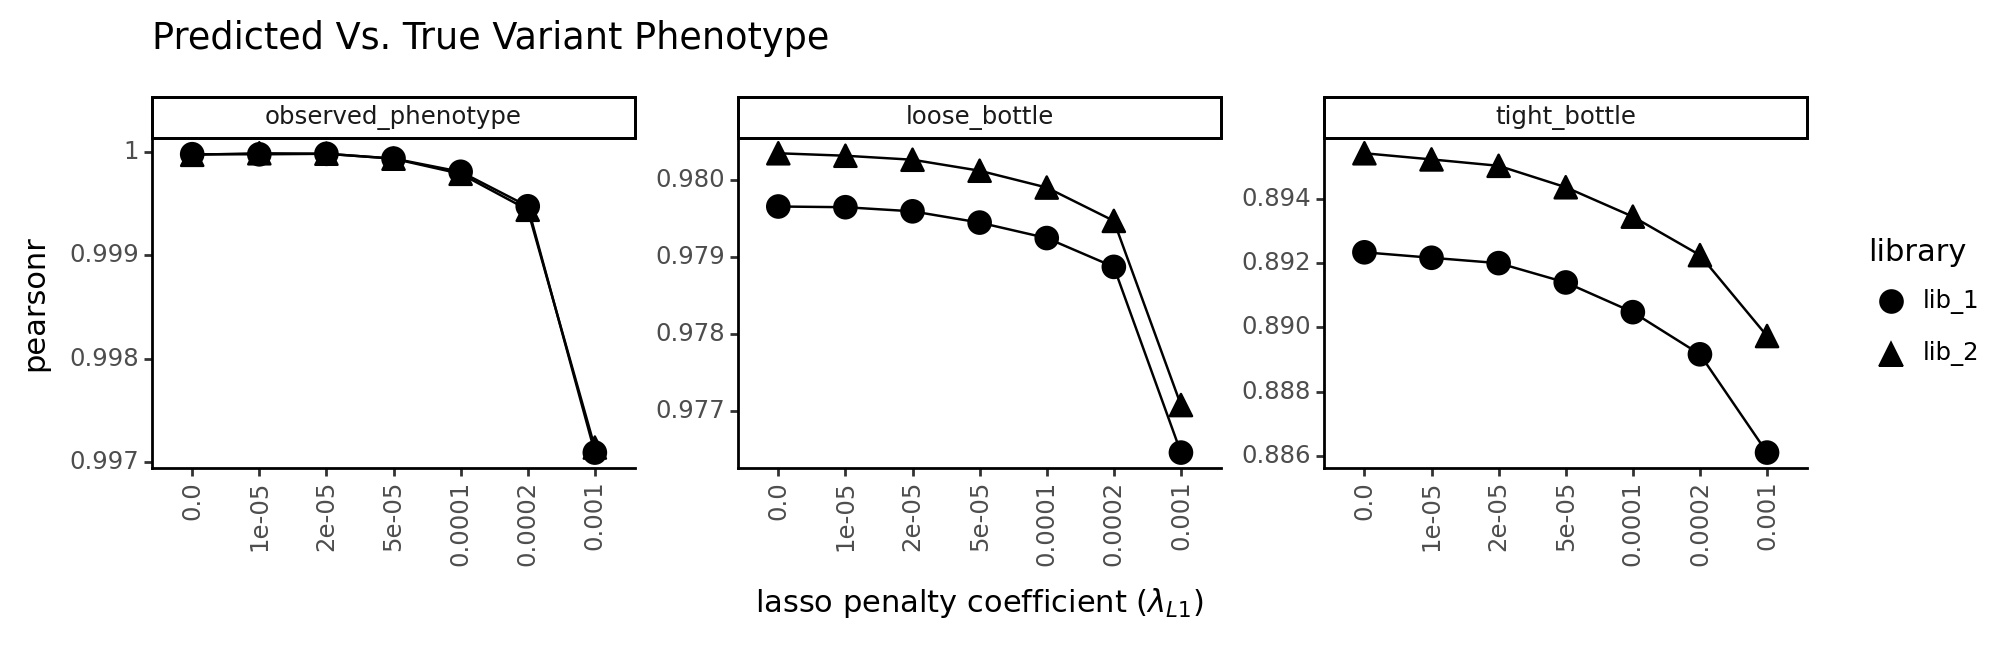

In [51]:
# for metric in ["corr", "mae"]:

metric = "corr"
p = (
    ggplot(
        fit_collection_df
        .assign(
            measurement_library = lambda x: x["library"] + "_" + x["measurement_type"].astype(str)
        )
    )
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"variant_phenotype_{metric}",
            group="measurement_library",
        ),
    )
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"variant_phenotype_{metric}",
            shape="library"
        ),
        size=4
    )
    + facet_wrap("measurement_type", scales="free_y")
    + theme_classic()
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        title=f"Predicted Vs. True Variant Phenotype",
        x="lasso penalty coefficient ($\lambda_{L1}$)",
        y="pearsonr" if metric == "corr" else "mean absolute error"
    )
)
_ = p.draw(show=True)

As expected, the lasso constraint has a negative effect on the models' ability to predict the true latent and observed phenotypes. This is because a model with more freedom to choose parameters is likely to overfit to the training data. 


### Cross validation


Above, we saw evidence that the lasso negatively impacts the model performance on the training data. To test for overfitting, we can perform cross validation to test that the model is actually more accurate on unseen data. We do this by breaking the variant data into a training and test set, and then fitting the model to the training set and evaluating the model on the test set:

In [52]:
train, test = [], {}
for (library, measurement), fs_df in func_scores.groupby(["library", "func_score_type"]):
    
    if "enrichment" in measurement:
        continue

    dataset = fs_df.sample(frac=1, random_state=seed)
    train_split, test_split = dataset.iloc[:int(len(dataset) * train_frac)], dataset.iloc[int(len(dataset) * train_frac):]
    name = f"{library}_{measurement}"
    
    train.append(
        multidms.Data(
            train_split, 
            reference="h1", 
            alphabet = multidms.AAS_WITHSTOP_WITHGAP, 
            verbose=False,
            name = name
        )
    )

    test[name] = test_split

In [53]:
fitting_params["dataset"] = train 
_, _, fit_collection_cv = multidms.model_collection.fit_models(fitting_params)

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun 

The `multidms.ModelCollection.add_validation_loss` method takes in unseen data, computes model loss on that data, and appends it to the `ModelCollection.fit_models` dataframe.

In [54]:
mc = multidms.model_collection.ModelCollection(fit_collection_cv)
mc.add_validation_loss(test, overwrite=True)
mc.fit_models[["dataset_name", "scale_coeff_lasso_shift", "training_loss", "validation_loss"]].head()

dataset_name scale_coeff_lasso_shift  training_loss  validation_loss
0  lib_1_loose_bottle                     0.0       0.223736         0.251529
1  lib_1_loose_bottle                 0.00001       0.224074         0.245599
2  lib_1_loose_bottle                 0.00002       0.224694         0.242851
3  lib_1_loose_bottle                 0.00005       0.226657         0.240144
4  lib_1_loose_bottle                  0.0001       0.229346         0.241085

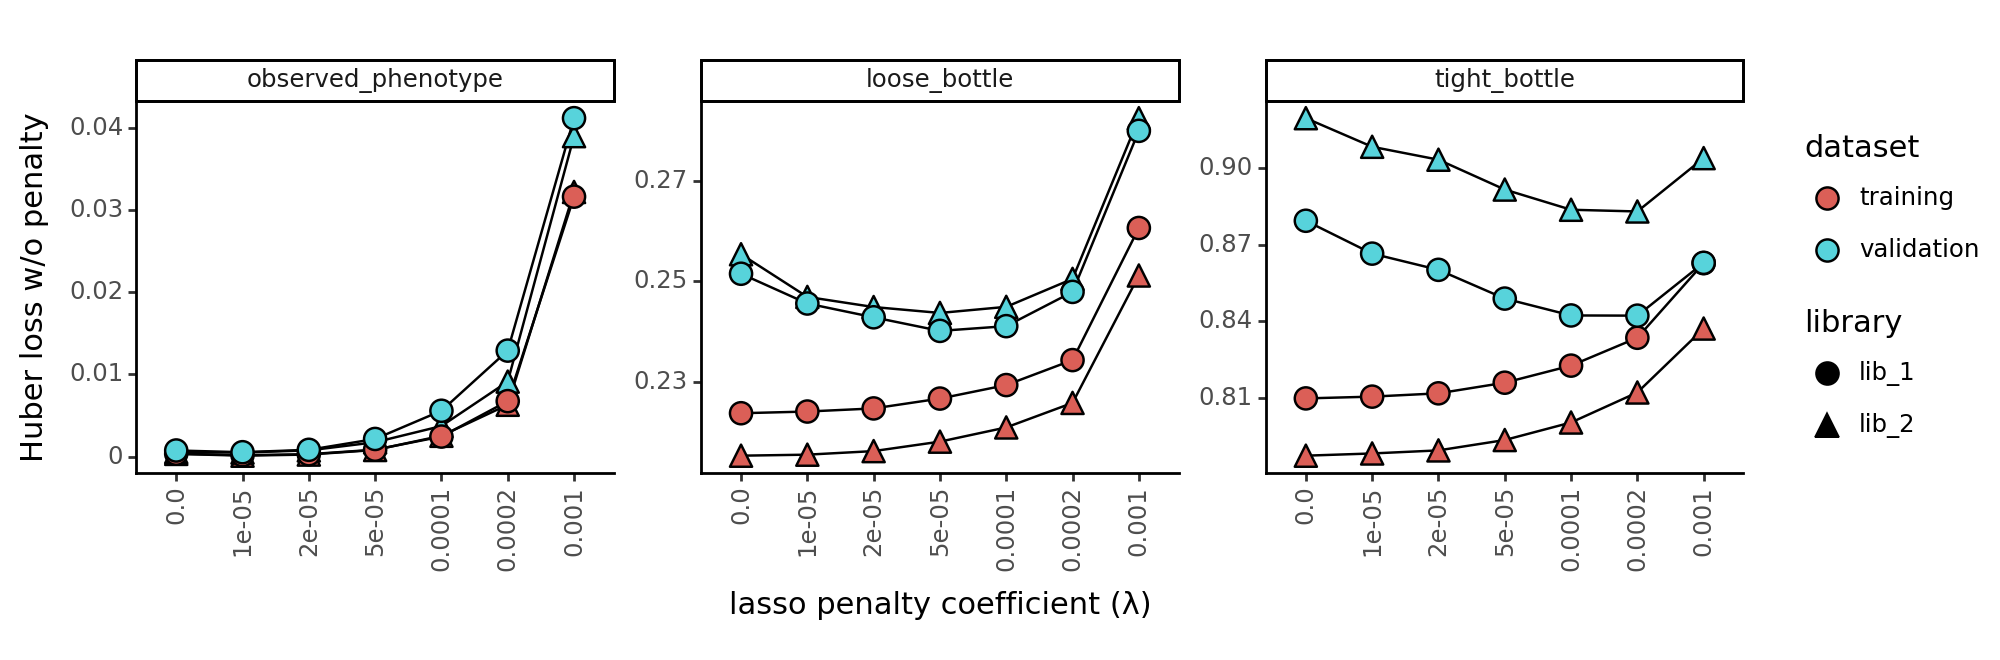

In [55]:
data = mc.fit_models

data["library"] = data["dataset_name"].str.split("_").str[0:2].str.join("_")
data["measurement_type"] = data["dataset_name"].str.split("_").str[2:4].str.join("_")
data["measurement_type"] = pd.Categorical(
    data["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

data = (
    data
    .melt(
        id_vars=["scale_coeff_lasso_shift", "library", "measurement_type"],
        value_vars=["training_loss", "validation_loss"],
        var_name="dataset",
        value_name="loss",
    )
    .assign(
        dataset = lambda x: x["dataset"].str.replace("_loss", "")
    )
    .assign(
        lib_dataset = lambda x: x["library"] + " " + x["dataset"]
    )
)
p = (
    ggplot(data)
    + geom_line(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            group="lib_dataset",
        )
    )
    + geom_point(
        aes(
            x="scale_coeff_lasso_shift",
            y=f"loss",
            fill="dataset",
            shape="library"
        ),
        size=4
    )
    + facet_wrap("measurement_type", scales="free_y")
    + theme_classic()
    + theme(
        figure_size=(10, 3.3),
        axis_text_x=element_text(angle=90),
        panel_grid_major_x=element_blank(),  # no vertical grid lines
    )
    + labs(
        x="lasso penalty coefficient (λ)",
        y="Huber loss w/o penalty"
    )
)
_ = p.draw(show=True)

Above we can see that indeed for both the loose and tight bottleneck datasets, the lasso constraint provides a more robust model to unseen data. We don't however see this effect for the models trained on ground truth observed phenotypes, as there is no noise for the models to overfit to.

### Final Selection

This analysis above provides a number of clues to inform our choice of model. With empricial data we obviously won't have comparisons to the ground truth values, and thus the choice of a lasso penalty will laregely depend on the shift parameter sparsity, correlation of inferred mutational effects between replicate libraries, and cross validation performance. Focusing on the _loose bottleneck_ training dataset (a fairly realistic level of noise that we often observe in real experiments), it seems that a lasso penalty of $1e-4$ provides a false positive rate of nearly zero (i.e. the stop codon sparsity $\approx 100\%$), a good correlation of inferred mutational effects between replicate libraries (>0.95 pearsonr), and a relatively low loss on validation when compared to the other models.  

## Model Evaluation

To validate the ability to correctly infer the shape of epistasis, we'll plot the inferred global epistasis function for each of the models, and compare it to the true global epistasis function.

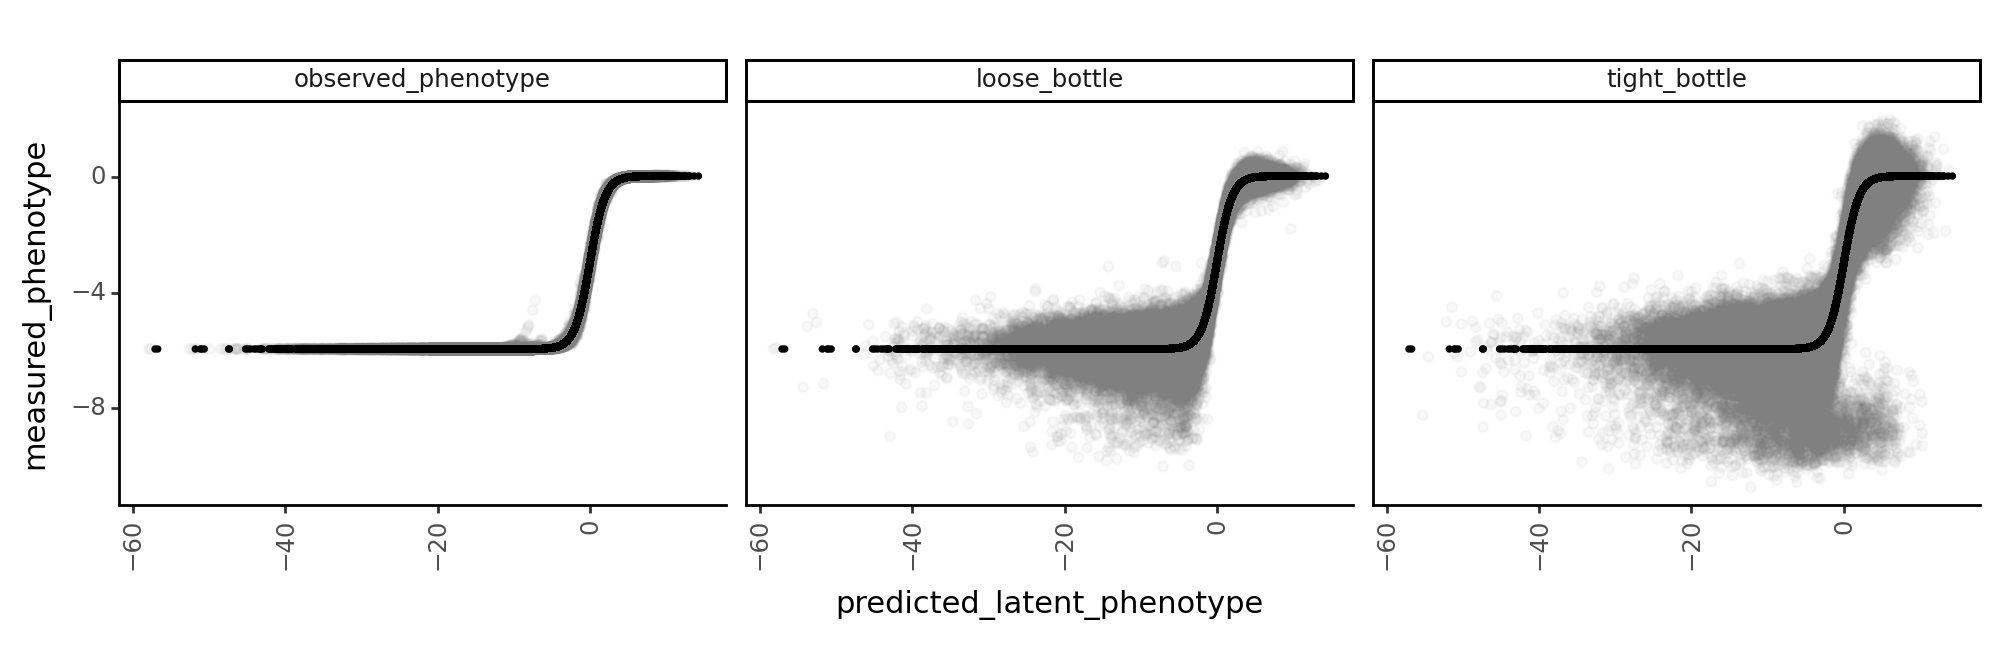

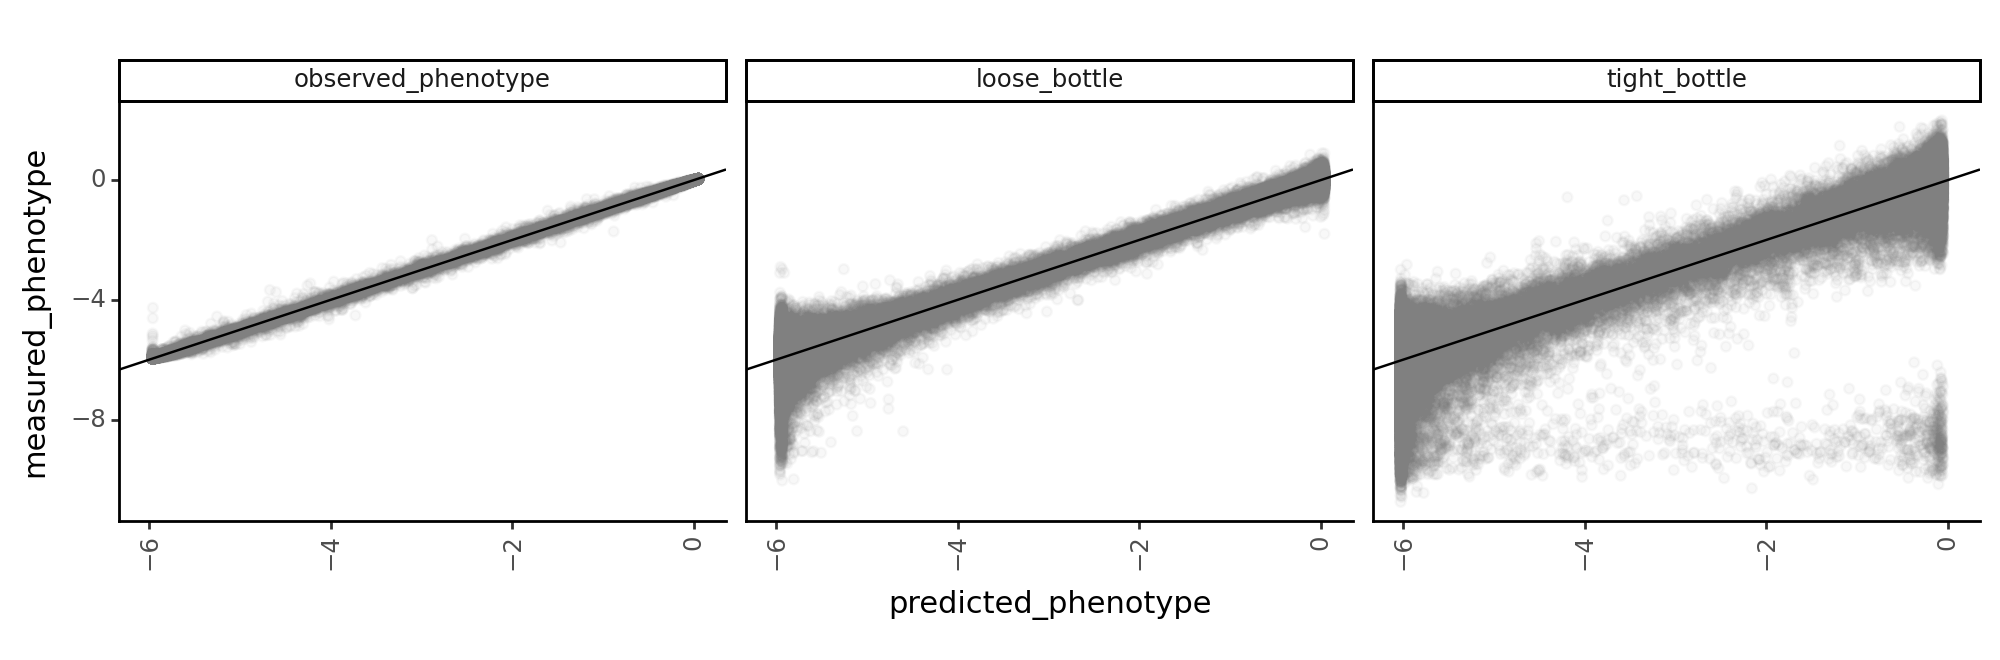

In [56]:
data = variants_df.query(f"scale_coeff_lasso_shift == {lasso_choice}")
for x, y in itertools.combinations(
    ["predicted_latent_phenotype", "predicted_phenotype", "measured_phenotype"], 2
):
    p = (
        ggplot(data.sample(frac=1.0))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.05,
            color="grey"
        )
        # ground truth 
        + ylab(y)
        + xlab(x)
        + facet_grid("~measurement_type")
        + theme_classic()
        + theme(
            # figure_size=(3 * len(libs), 2.5 * len(data["measurement_type"].unique())),
            figure_size=(10, 3.3),
            axis_text_x=element_text(angle=90),
        )
    )

    if x == "predicted_latent_phenotype":
        p+= geom_point(
            aes(
                x="true_latent_phenotype",
                y="true_observed_phenotype"
            ),
            size=0.5,
        )
    else:
        p += geom_abline(
            slope=1,
            intercept=0, 
        )

    
        
    _ = p.draw(show=True)

Plot model vs. measured (functional score) vs. ground truth enrichments.

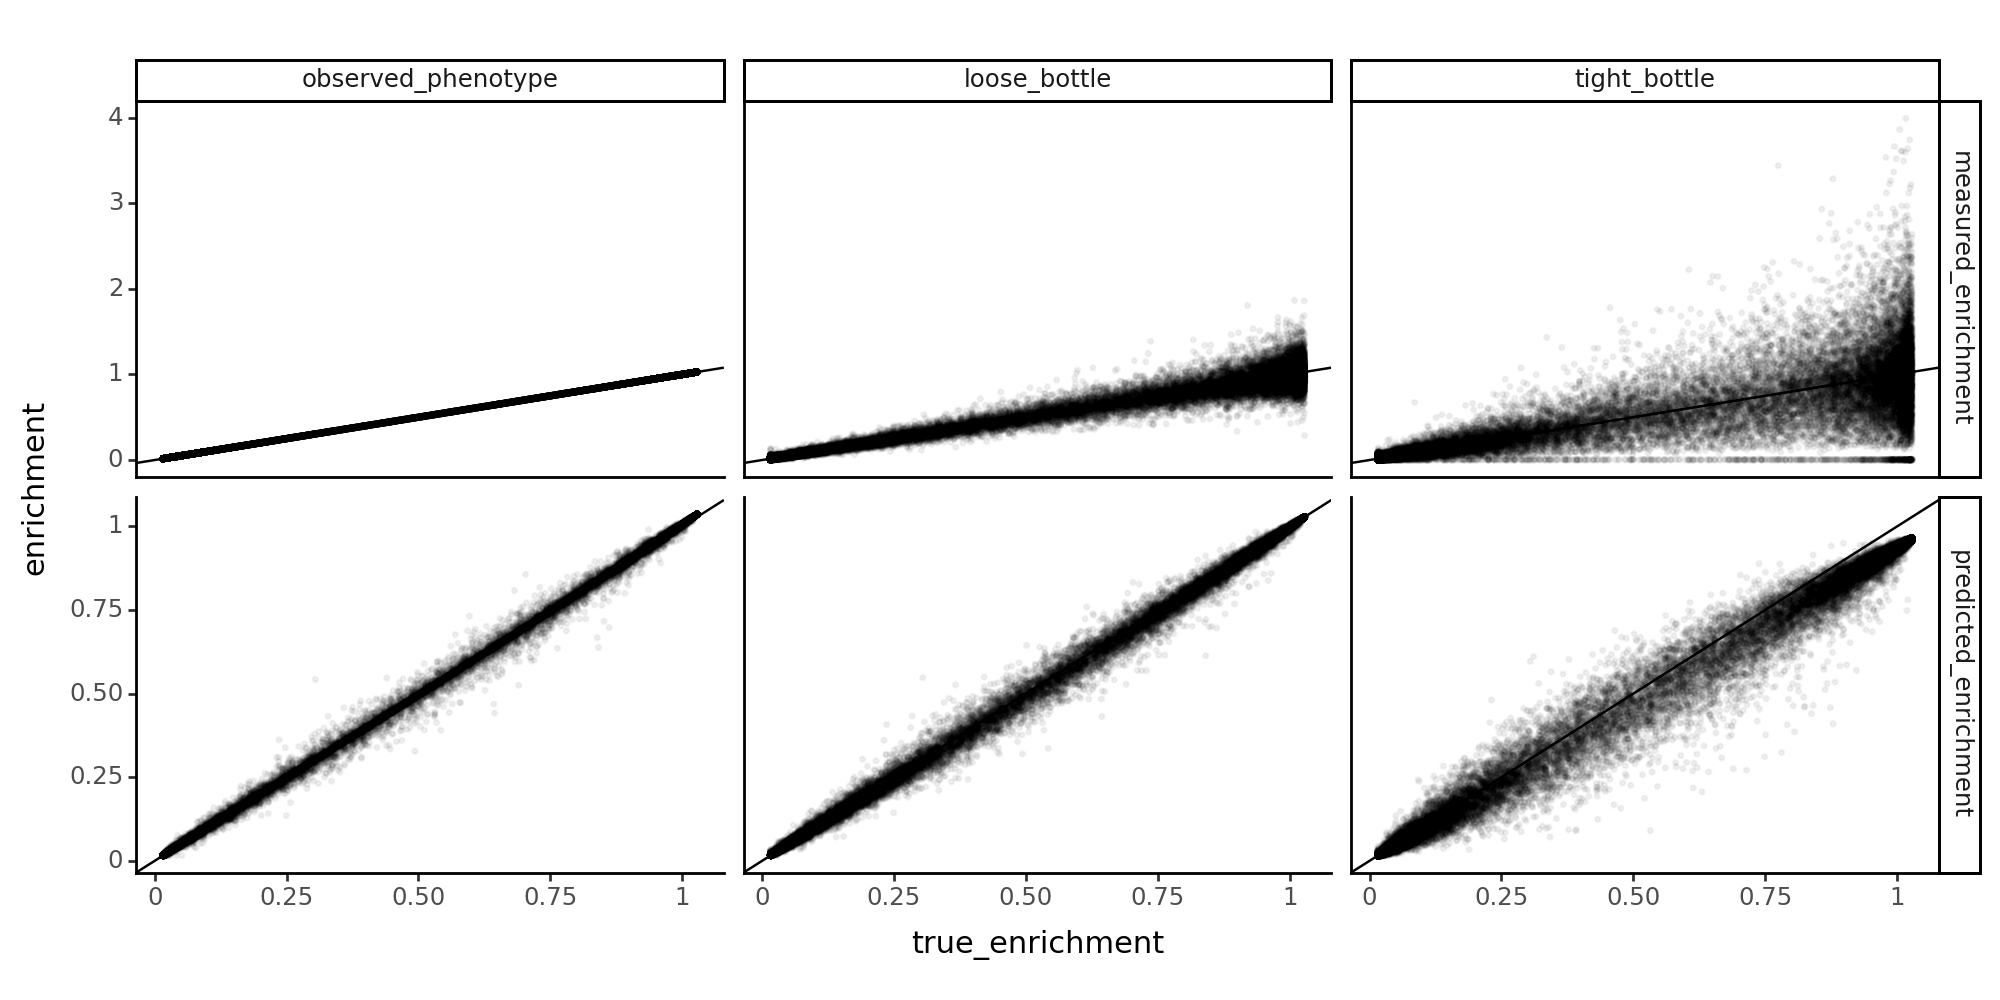

In [57]:
p = (
    ggplot(
        data.melt(
            # id_vars=["measurement_type", "library", "condition", "true_enrichment"],
            id_vars=["measurement_type", "library", "true_enrichment"],
            value_vars=["predicted_enrichment", "measured_enrichment"],
            var_name="enrichment_type",
            value_name="enrichment",
        ),
        # variants_df,
        aes("true_enrichment", "enrichment"),
    )
    + geom_abline(
        slope=1,
        intercept=0, 
        # alpha=0.5,
        # size=0.5,
    )
    + geom_point(alpha=0.05, size=0.5)
    + facet_grid("enrichment_type~measurement_type", scales="free_y")
    + theme_classic()
    + theme(
        figure_size=(10, 5),
    )
)

_ = p.draw(show=True)

Amazingly, the model does better at predicting true enrichments than even the counts based functional scores!

Finally, let's plot the relationship between the model's inferred shifts, and the ground truth shifts. 

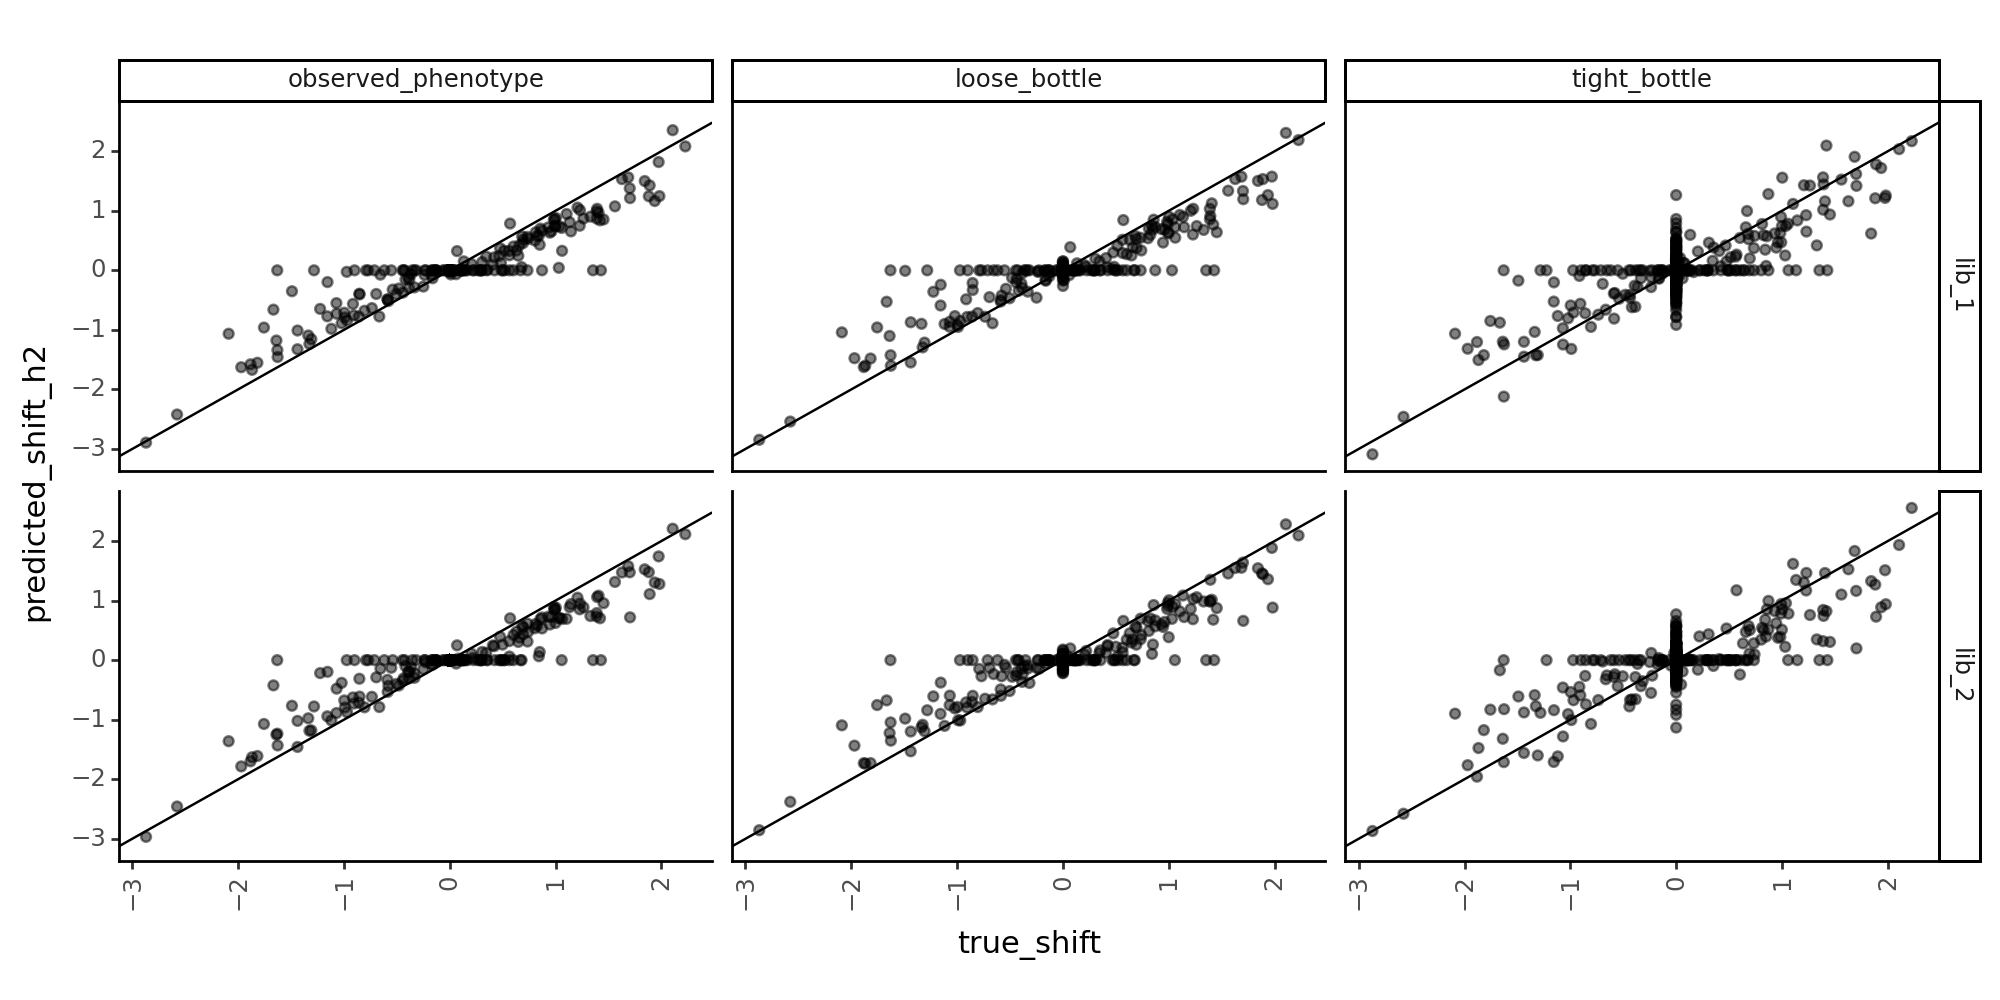

In [68]:
# plot correlations of true and predicted shifts
collection_muts_df["measurement_type"] = pd.Categorical(    
    collection_muts_df["measurement_type"],
    categories=["observed_phenotype", "loose_bottle", "tight_bottle"],
    ordered=True
)

for (x, y) in itertools.combinations(
    ["true_shift", "predicted_shift_h2"], 2
):
    p = (
        ggplot(collection_muts_df.query(f"scale_coeff_lasso_shift == {lasso_choice}"))
        + geom_point(
            aes(
                x=x,
                y=y    
            ),
            alpha=0.5,
        )
        + geom_abline(
            slope=1,
            intercept=0, 
        )
        + ylab(y)
        + xlab(x)
        + facet_grid("library~measurement_type")
        + theme_classic()
        + theme(
            figure_size=(10, 5),
            axis_text_x=element_text(angle=90),
        )
    )
    _ = p.draw(show=True)